In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install fair-esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
%cd "/content/drive/MyDrive/Hackathon/"
import numpy as np
from neural_net import get_net_scores, train_net, prepare_loader, SimpleDenseNet
from pep_utils import load_peptide_data, get_peptide_distances, pep_train_test_split
from plot import plot_boxplot, plot_roc_curve, plot_esm_amino_acids_embeddings, plot_2dim_reduction
from esm_embeddings import get_esm_embeddings, get_esm_model
from clustering import kmeans_clustering, tsne_dim_reduction

/content/drive/MyDrive/Hackathon


In [ ]:
def simple_score(p_train, n_train, p_test, n_test):
    """
    Distance-based baseline.
    For every peptide in test we compute its mean Euclidean distance
    to all positive-training embeddings and all negative-training
    embeddings.  The final score is a signed log-fold-difference:

        score  =  log1p(dist_to_neg) – log1p(dist_to_pos)

    So a higher score -> more “positive-like”, because
    distance-to-negatives is large while distance-to-positives is small.

    :param p_train: Positive-class train embeddings.
    :param n_train: Negative-class train embeddings.
    :param p_test: Positive-class test embeddings.
    :param n_test: Negative-class test embeddings.
    :return: Scores for the positive-test set, Scores for the negative-test set (np.ndarray, np.ndarray).
    """
    positive_mean_distances_pos = get_peptide_distances(p_test, p_train, reduce_func=np.mean)
    negative_mean_distances_pos = get_peptide_distances(n_test, p_train, reduce_func=np.mean)
    positive_mean_distances_neg = get_peptide_distances(p_test, n_train, reduce_func=np.mean)
    negative_mean_distances_neg = get_peptide_distances(n_test, n_train, reduce_func=np.mean)

    p_score = np.log1p(positive_mean_distances_neg) - np.log1p(positive_mean_distances_pos)
    n_score = np.log1p(negative_mean_distances_neg) - np.log1p(negative_mean_distances_pos)

    return p_score, n_score

In [ ]:
def run_with_configuration(
    chosen_embedding_size=320,
    chosen_embedding_layer=6,
    chosen_test_size=0.2,
    batch_size = 64,
    epochs = 50,
    lr = 1e-3,
    hidden_dim = 128,
    dropout = 0.4,
    name="/content/drive/MyDrive/Hackathon/results/"):

    # Load all the peptide data
    print("Loading peptide data")
    positive_pep, negative_pep, doubt_lables = load_peptide_data()

    # Load the pre-trained ESM-2 model with the desired embedding size
    print("Loading ESM-2 model")
    model_esm, alphabet_esm, batch_converter_esm, device_esm = get_esm_model(embedding_size=chosen_embedding_size)

    print("Getting ESM-2 amino acid embeddings for the first negative and positive peptides")
    # Get amino acids embedding of the first negative and first positive peptides
    positive_aa_embeddings = get_esm_embeddings(positive_pep[0:1], model_esm, alphabet_esm, batch_converter_esm, device_esm,
                                          embedding_layer=chosen_embedding_layer, sequence_embedding=False)[0]
    negative_aa_embeddings = get_esm_embeddings(negative_pep[0:1], model_esm, alphabet_esm, batch_converter_esm, device_esm,
                                          embedding_layer=chosen_embedding_layer, sequence_embedding=False)[0]
    print("Plotting heatmaps of the amino acid embedding")
    plot_esm_amino_acids_embeddings(positive_aa_embeddings, out_file_path=name +"positive_heatmap.png")
    plot_esm_amino_acids_embeddings(negative_aa_embeddings, out_file_path=name +"negative_heatmap.png")


    # Get the ESM-2 sequence embeddings from all the negative and positive peptides
    print("Getting the ESM-2 embeddings for all the peptide data")
    positive_esm_emb = get_esm_embeddings(positive_pep, model_esm, alphabet_esm, batch_converter_esm, device_esm,
                                          embedding_layer=chosen_embedding_layer, sequence_embedding=True)
    negative_esm_emb = get_esm_embeddings(negative_pep, model_esm, alphabet_esm, batch_converter_esm, device_esm,
                                          embedding_layer=chosen_embedding_layer, sequence_embedding=True)

    # Clustering and Dimensionality reduction
    print("Clustering using K-means clustering and reduce to dim=2 using TSNE")
    all_esm_embeddings =  negative_esm_emb + positive_esm_emb
    all_labels = [0] * len(negative_esm_emb) + [1] * len(positive_esm_emb)

    k_means_labels = kmeans_clustering(all_esm_embeddings, k=2)
    coords_2d = tsne_dim_reduction(all_esm_embeddings, dim=2)

    print("Plotting 2D dimensionality reduction by true labels and by K-means clustering")
    plot_2dim_reduction(coords_2d, [["N", "P"][i] for i in all_labels], out_file_path= name + "2d_true_labels.png")
    plot_2dim_reduction(coords_2d, k_means_labels, out_file_path=name + "2d_k_means.png")


    # Split the data into train and test sets
    print("Splitting to train and test sets")
    positive_train, negative_train, is_doubt_train, positive_test, negative_test, is_doubt_test = pep_train_test_split(
        positive_esm_emb, negative_esm_emb, doubt_lables, test_size=chosen_test_size)

    print("Calculating euclidean distances of ESM-2 embeddings")
    # Calculate a score based on the log fold difference between distance to negative mean and positive mean
    positive_score, negative_score = simple_score(positive_train, negative_train, positive_test, negative_test)

    # Plot the results in a boxplot and in a ROC curve
    print("Plotting Baseline results")
    plot_boxplot({"Positive Test": positive_score, "Negative Test": negative_score}, out_file_path=name + "baseline_boxplot.png")
    plot_roc_curve([0] * len(negative_score) + [1] * len(positive_score), np.concatenate([negative_score, positive_score]), out_file_path=name + "baseline_roc_curve.png")

    # Train a simple neural network
    print("Training a neural network on the training set")
    # Prepare a Dataloader and create model
    net_dataloader = prepare_loader(positive_train, negative_train, batch_size=batch_size)
    network = SimpleDenseNet(esm_emb_dim=chosen_embedding_size, hidden_dim=hidden_dim, dropout=dropout)
    trained_network = train_net(network, net_dataloader, num_epochs=epochs, lr=lr)

    print("Getting the trained network scores for the test set")
    positive_score = get_net_scores(trained_net=trained_network, esm_seq_embeddings=positive_test)
    negative_score = get_net_scores(trained_net=trained_network, esm_seq_embeddings=negative_test)

    print("Plotting Network results")
    plot_boxplot({"Positive Test": positive_score, "Negative Test": negative_score}, out_file_path=name + "network_boxplot.png")
    plot_roc_curve([0] * len(negative_score) + [1] * len(positive_score), np.concatenate([negative_score, positive_score]), out_file_path=name + "network_roc_curve.png")


Running network with the following configuration:
Embedding size: 320
Embedding layer: 2
Loading peptide data
Loading ESM-2 model
ESM model loaded to cuda
Getting ESM-2 amino acid embeddings for the first negative and positive peptides
Plotting heatmaps of the amino acid embedding
Getting the ESM-2 embeddings for all the peptide data
Clustering using K-means clustering and reduce to dim=2 using TSNE
Plotting 2D dimensionality reduction by true labels and by K-means clustering
Splitting to train and test sets
Calculating euclidean distances of ESM-2 embeddings
Plotting Baseline results
AUC: 0.8049127803488786
Training a neural network on the training set
Epoch 01/30 – loss: 0.6826
Epoch 02/30 – loss: 0.6390
Epoch 03/30 – loss: 0.5591
Epoch 04/30 – loss: 0.4821
Epoch 05/30 – loss: 0.4401
Epoch 06/30 – loss: 0.4244
Epoch 07/30 – loss: 0.3773
Epoch 08/30 – loss: 0.3787
Epoch 09/30 – loss: 0.3640
Epoch 10/30 – loss: 0.3493
Epoch 11/30 – loss: 0.3454
Epoch 12/30 – loss: 0.3477
Epoch 13/30 – 

/content/drive/MyDrive/Hackathon/plot.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))


Getting the ESM-2 embeddings for all the peptide data
Clustering using K-means clustering and reduce to dim=2 using TSNE
Plotting 2D dimensionality reduction by true labels and by K-means clustering
Splitting to train and test sets
Calculating euclidean distances of ESM-2 embeddings
Plotting Baseline results
AUC: 0.8241367034531862
Training a neural network on the training set
Epoch 01/30 – loss: 0.6920
Epoch 02/30 – loss: 0.6721
Epoch 03/30 – loss: 0.6497
Epoch 04/30 – loss: 0.5975
Epoch 05/30 – loss: 0.5518
Epoch 06/30 – loss: 0.5056
Epoch 07/30 – loss: 0.4696
Epoch 08/30 – loss: 0.4706
Epoch 09/30 – loss: 0.4388
Epoch 10/30 – loss: 0.4059
Epoch 11/30 – loss: 0.4212
Epoch 12/30 – loss: 0.4082
Epoch 13/30 – loss: 0.4060
Epoch 14/30 – loss: 0.3905
Epoch 15/30 – loss: 0.3773
Epoch 16/30 – loss: 0.3620
Epoch 17/30 – loss: 0.3436
Epoch 18/30 – loss: 0.3525
Epoch 19/30 – loss: 0.3532
Epoch 20/30 – loss: 0.3477
Epoch 21/30 – loss: 0.3203
Epoch 22/30 – loss: 0.3258
Epoch 23/30 – loss: 0.3356

<Figure size 1000x1000 with 0 Axes>

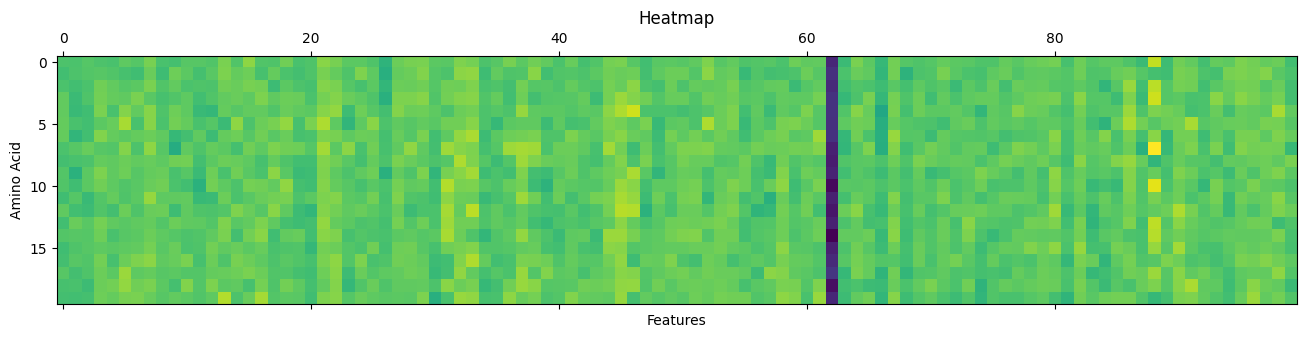

<Figure size 1000x1000 with 0 Axes>

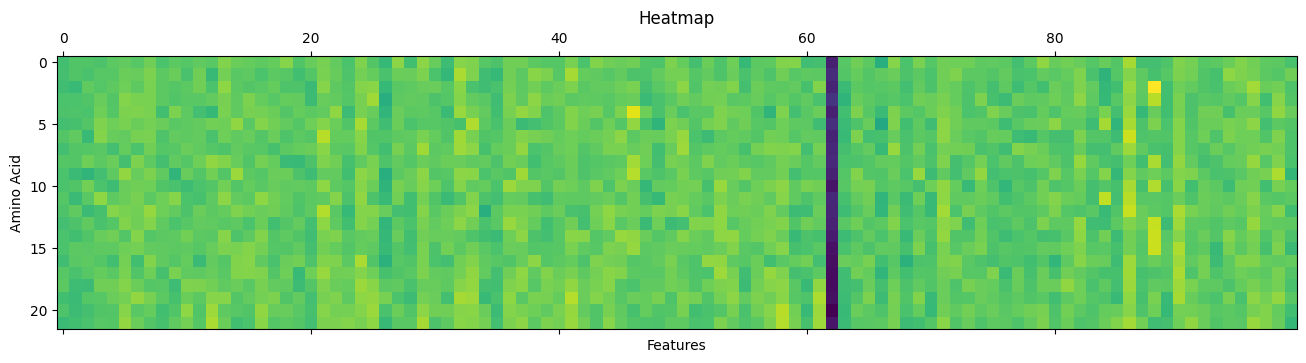

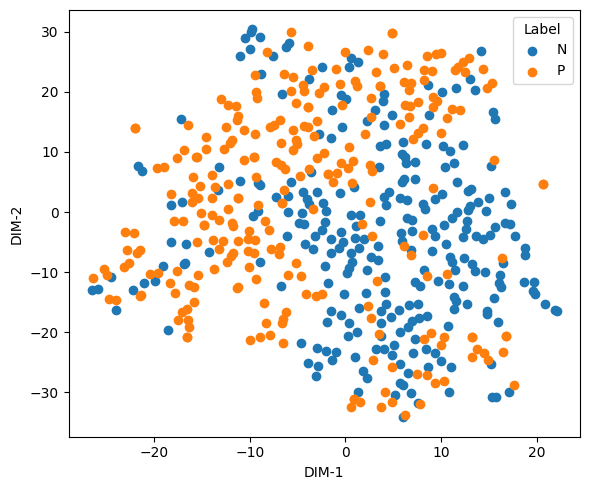

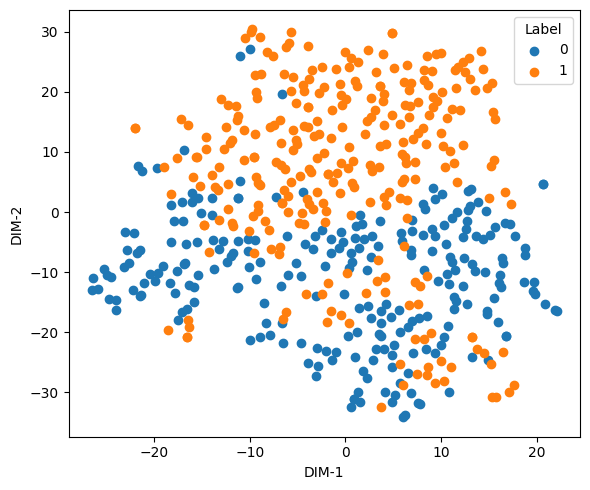

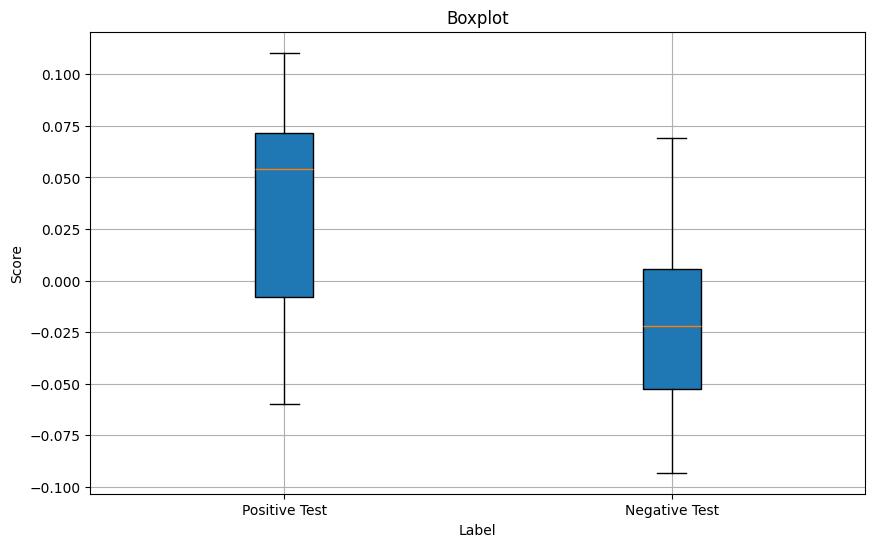

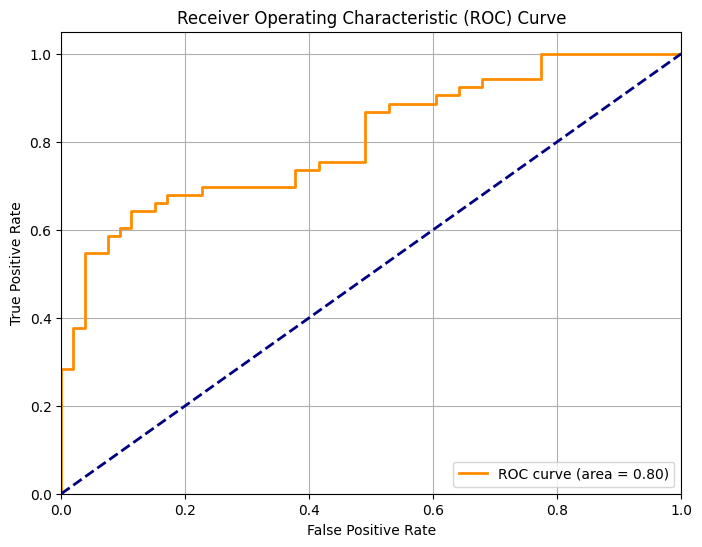

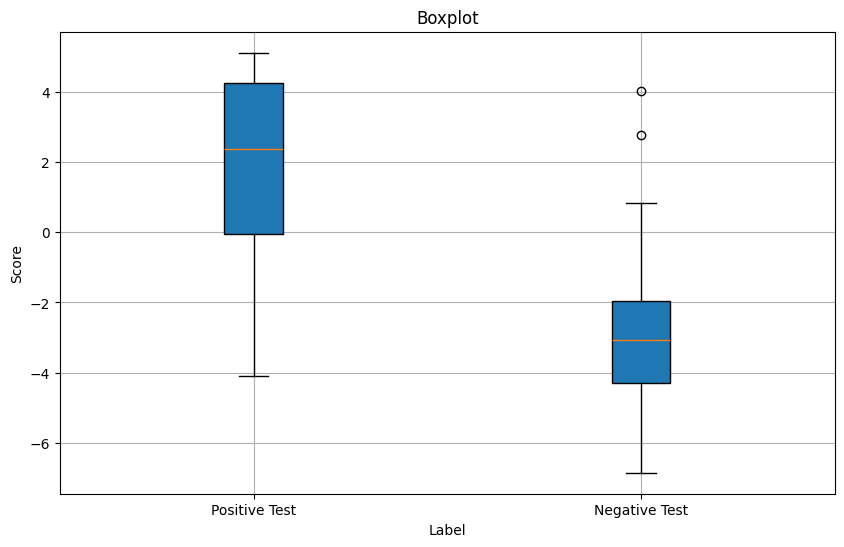

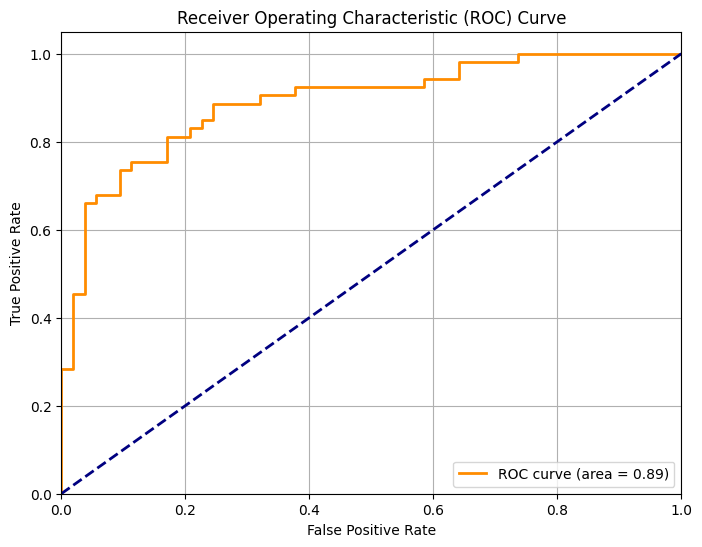

<Figure size 1000x1000 with 0 Axes>

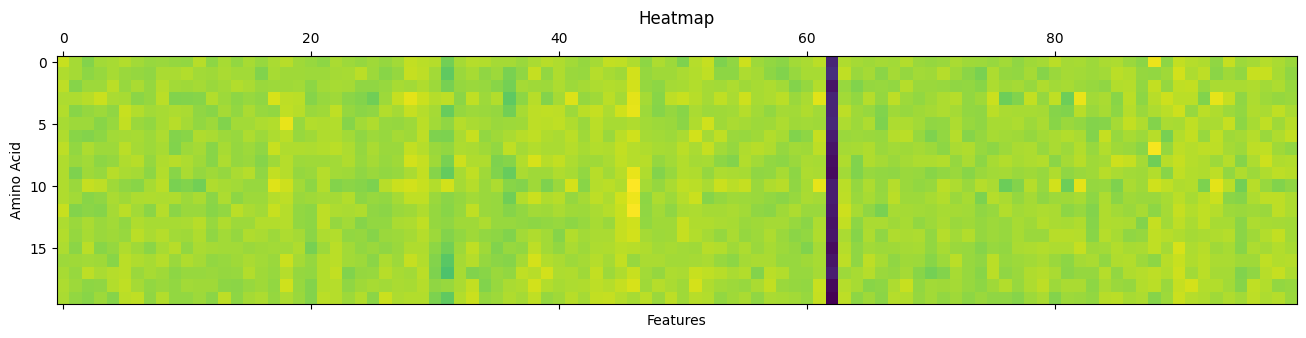

<Figure size 1000x1000 with 0 Axes>

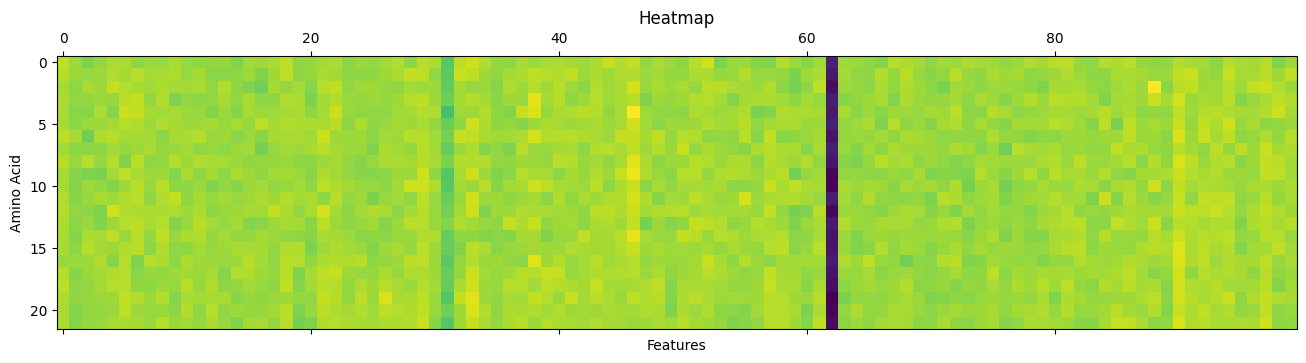

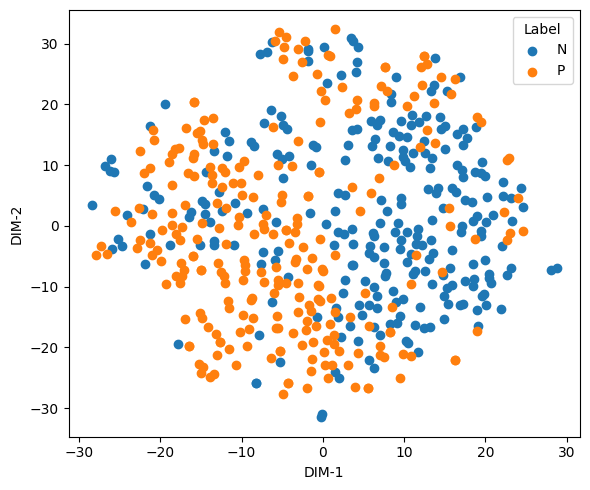

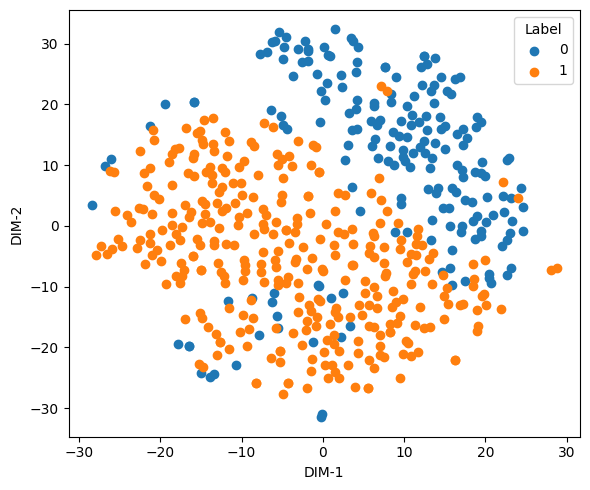

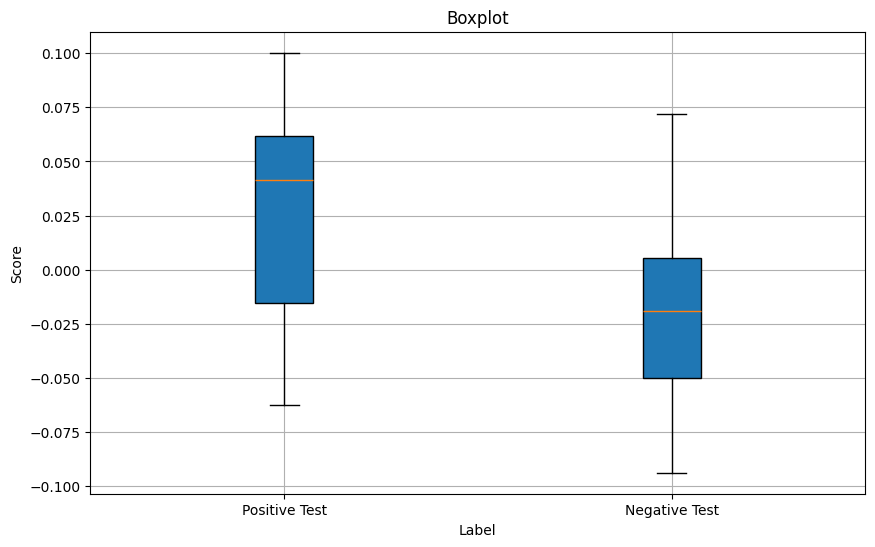

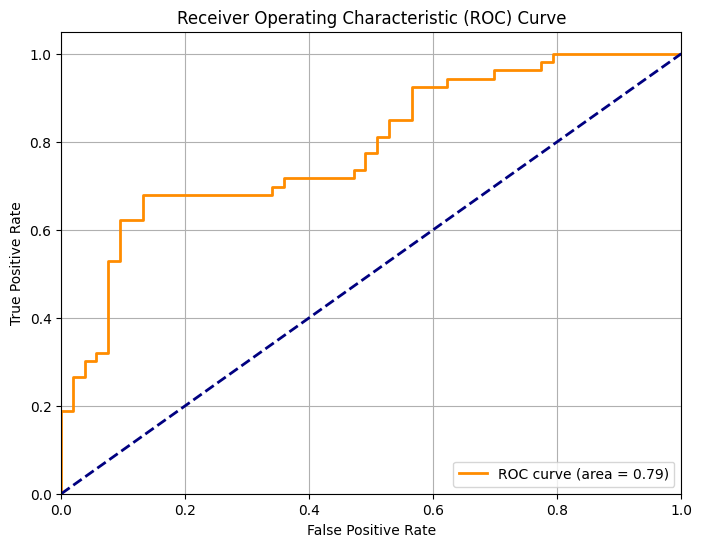

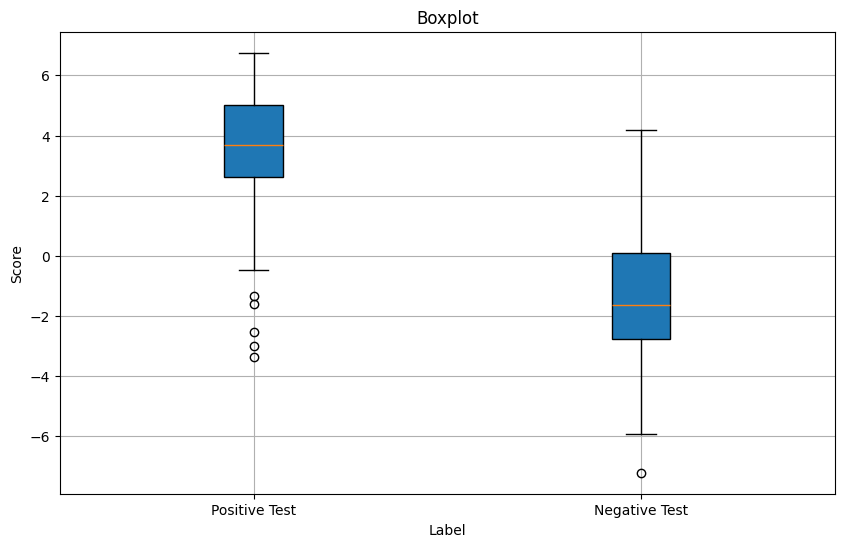

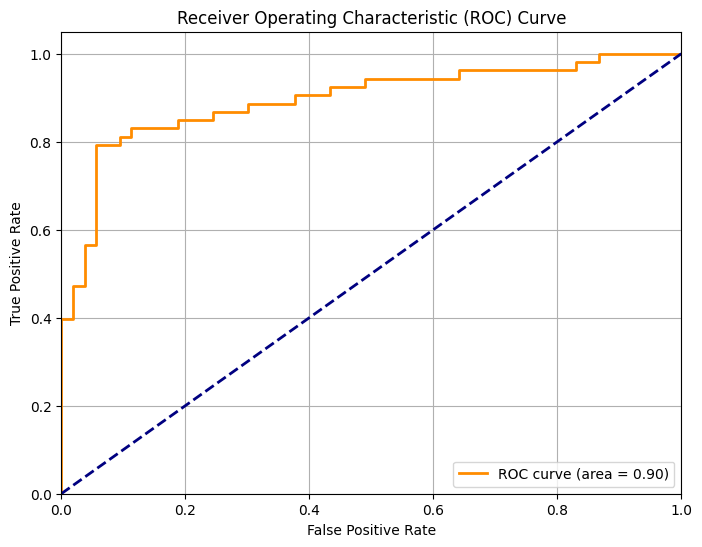

<Figure size 1000x1000 with 0 Axes>

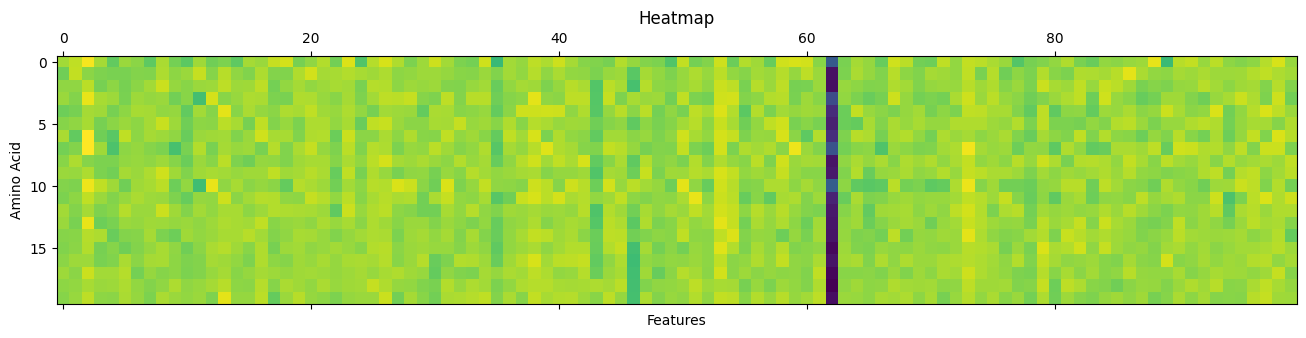

<Figure size 1000x1000 with 0 Axes>

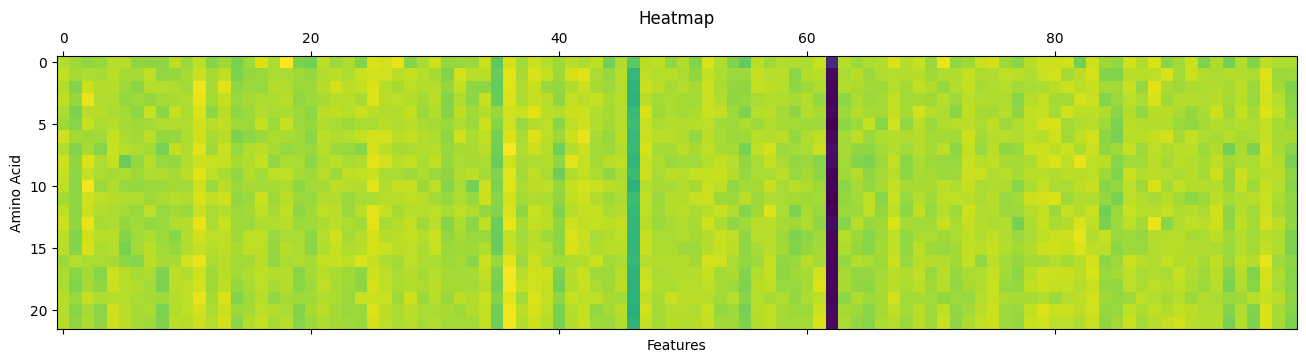

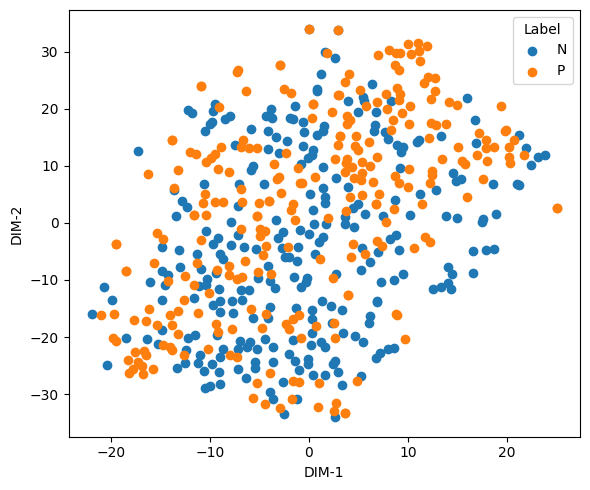

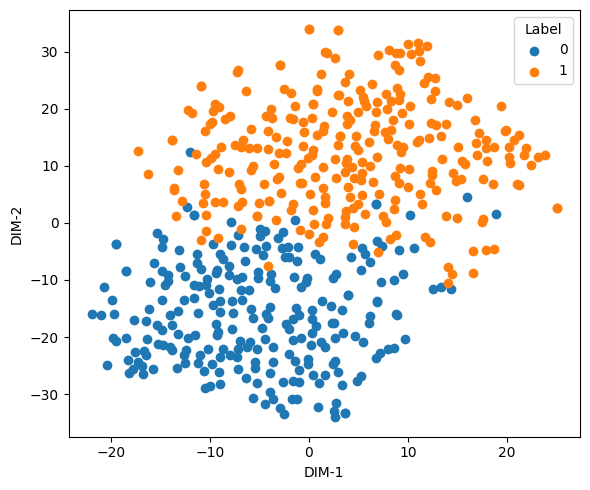

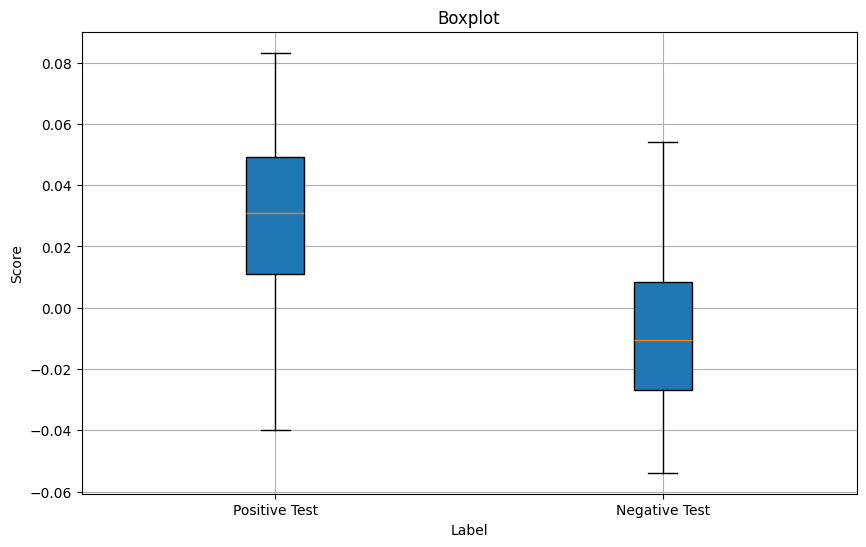

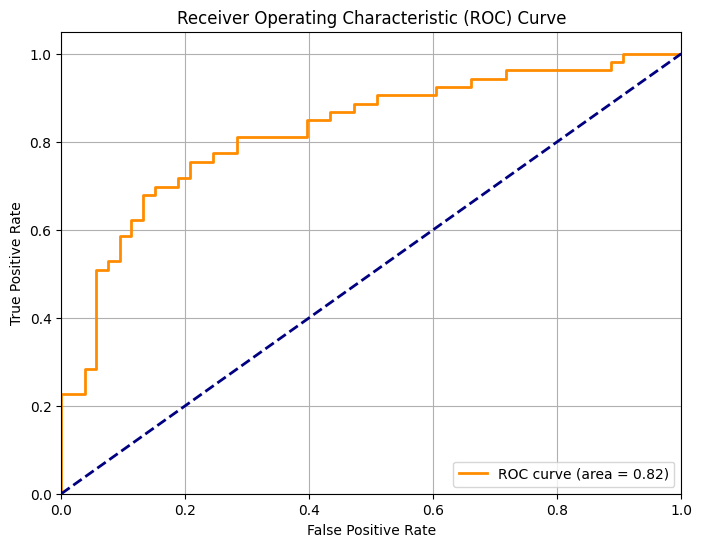

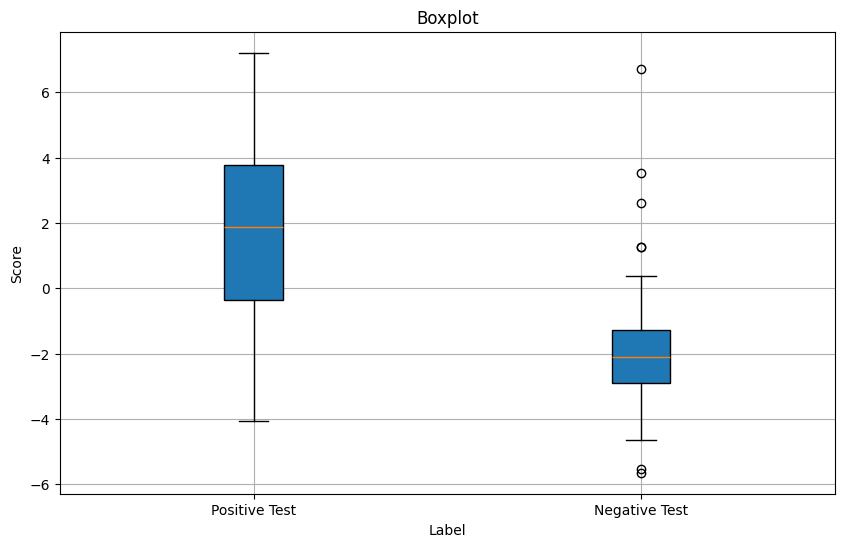

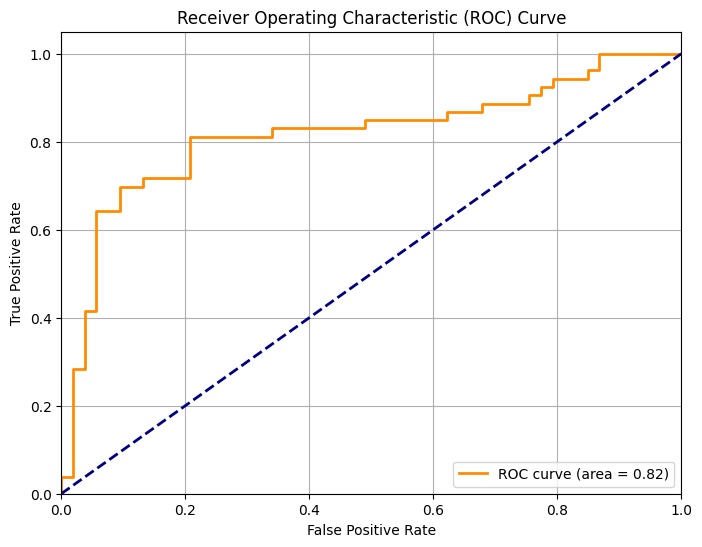

<Figure size 1000x1000 with 0 Axes>

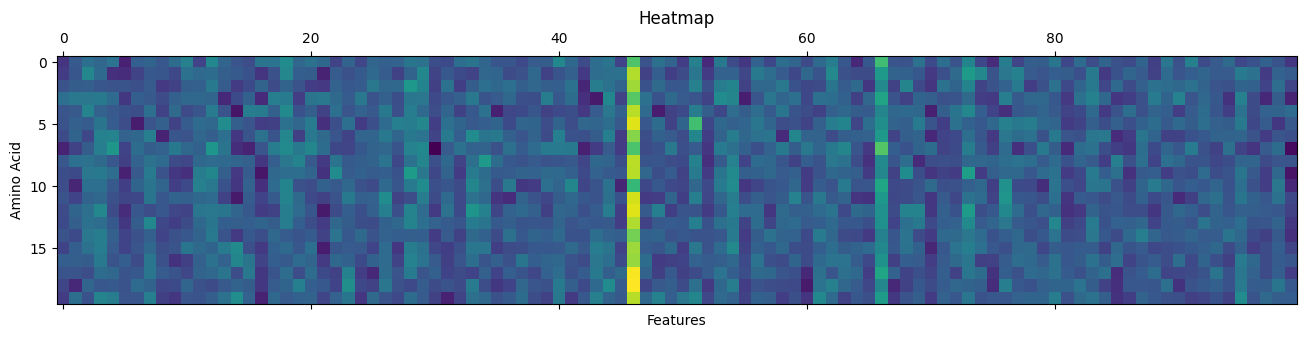

<Figure size 1000x1000 with 0 Axes>

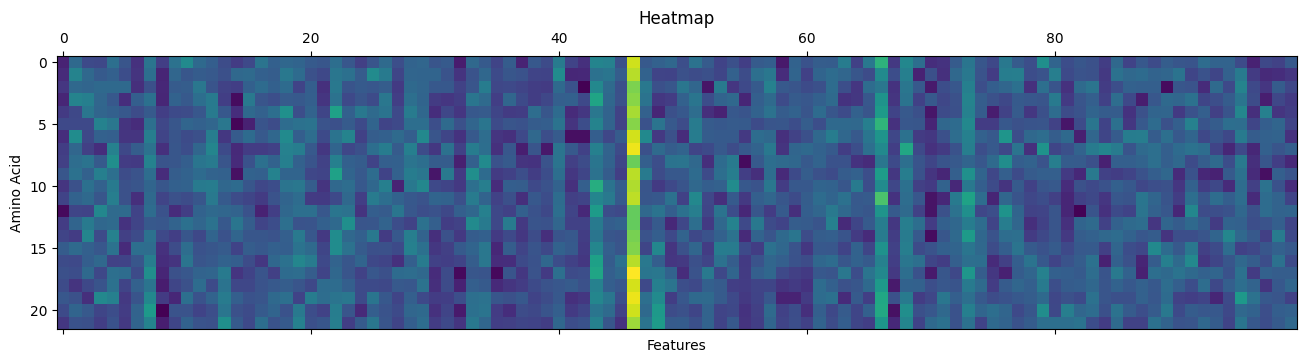

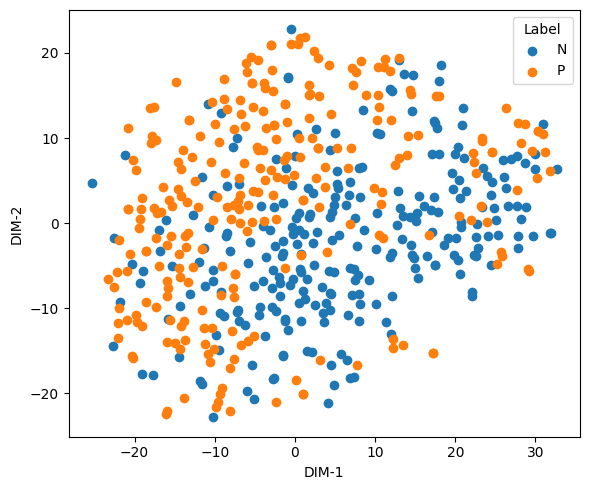

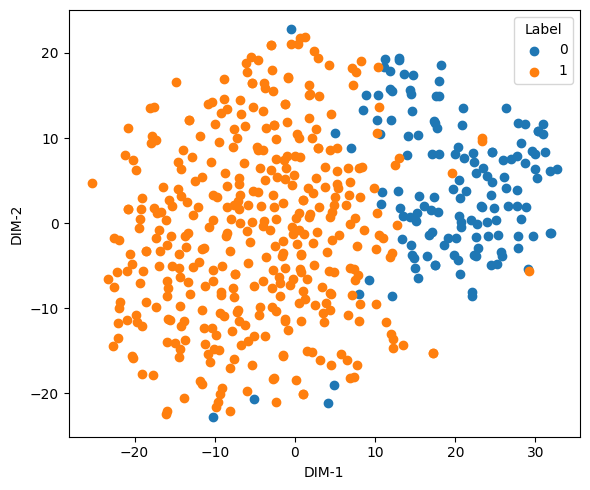

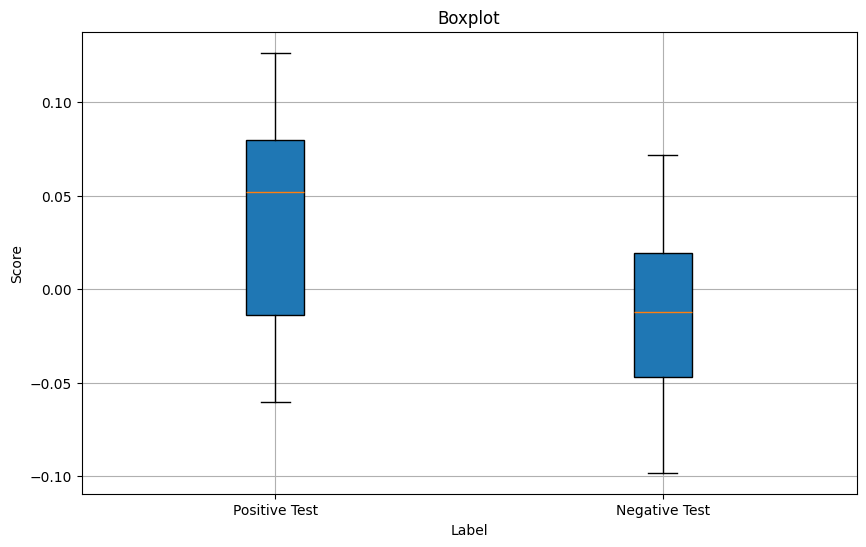

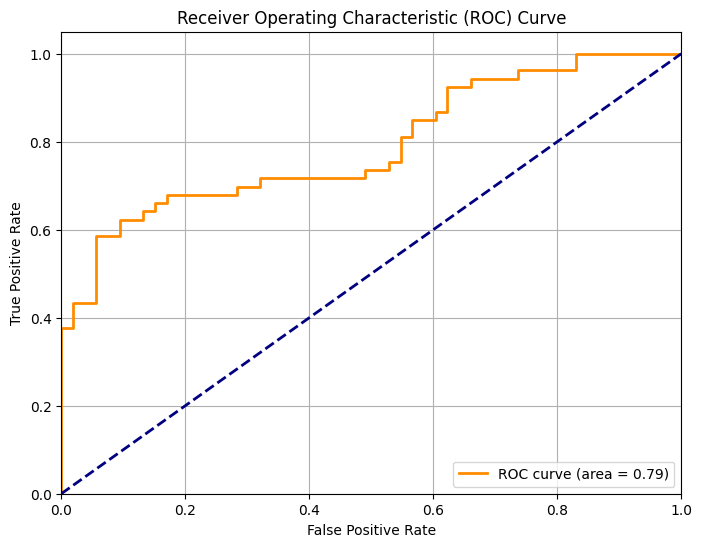

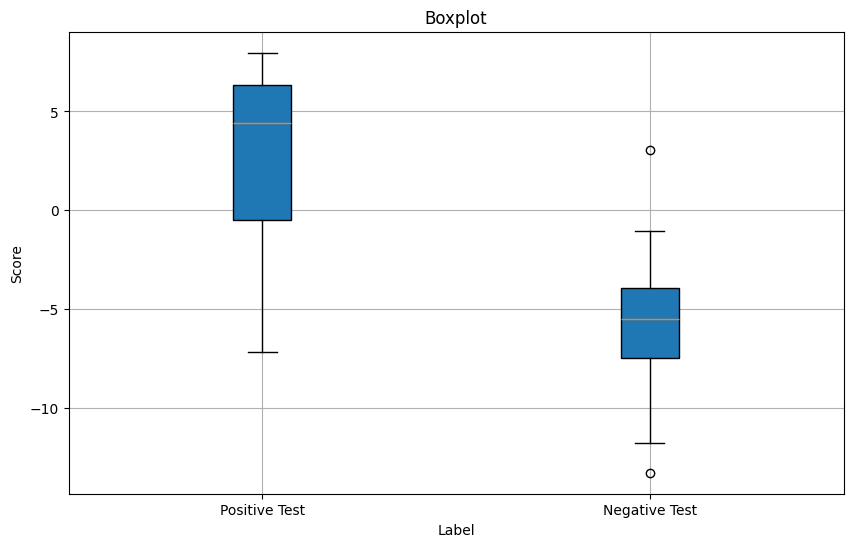

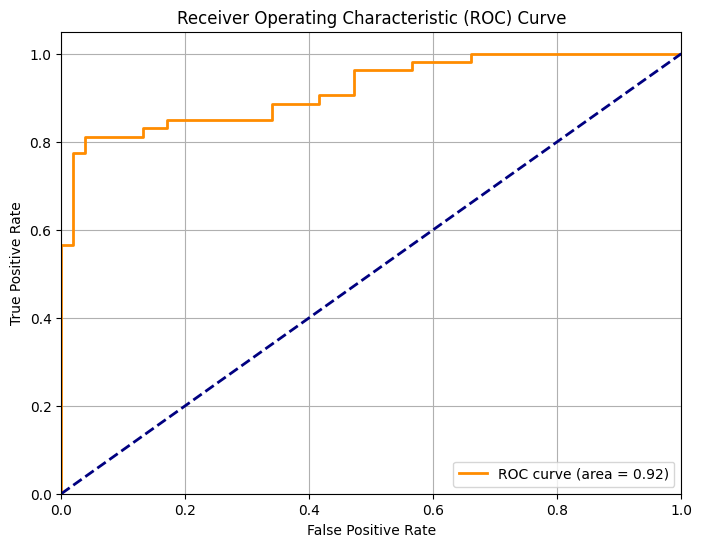

<Figure size 1000x1000 with 0 Axes>

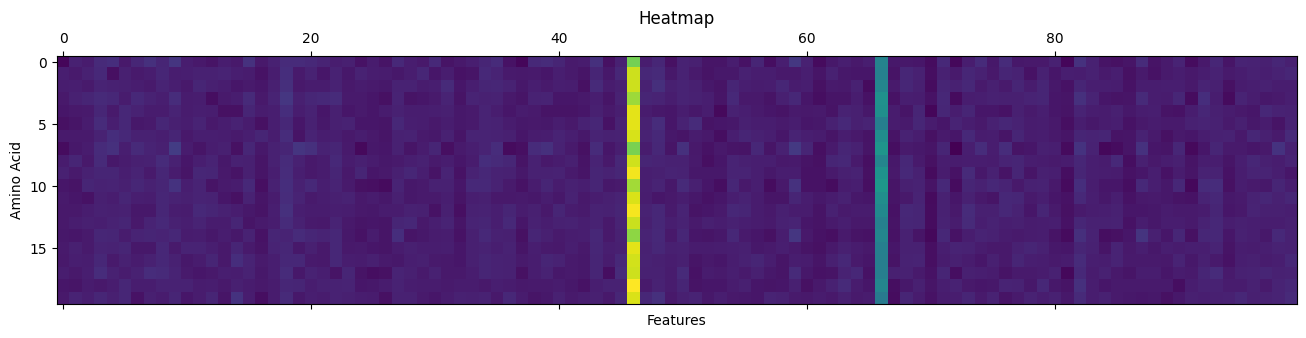

<Figure size 1000x1000 with 0 Axes>

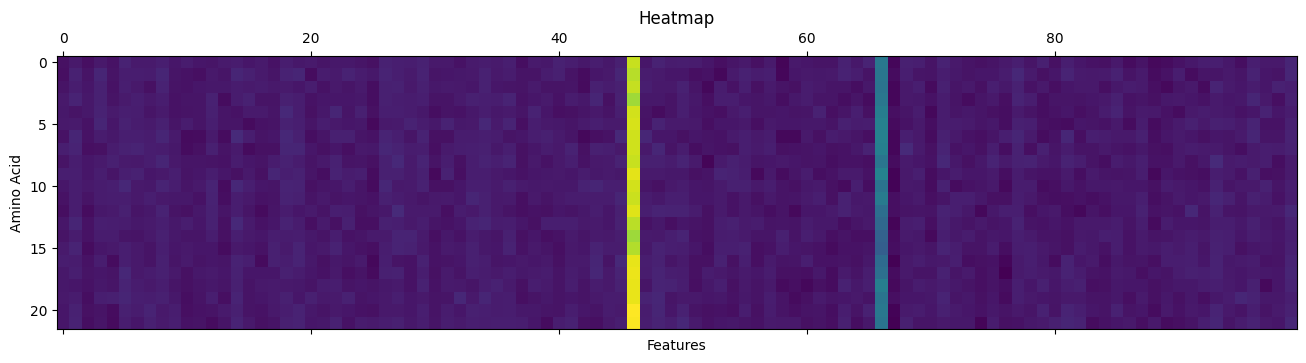

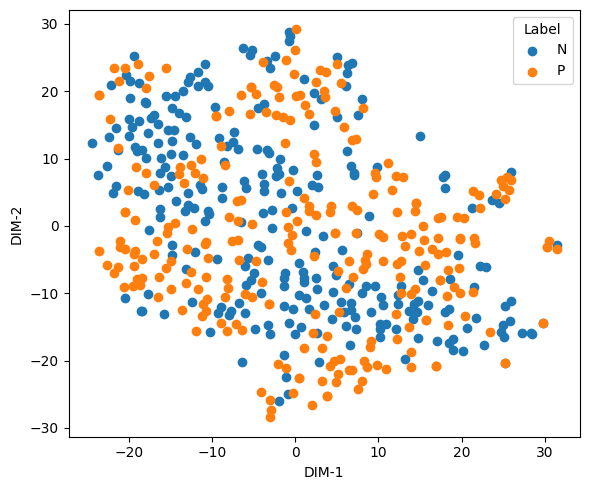

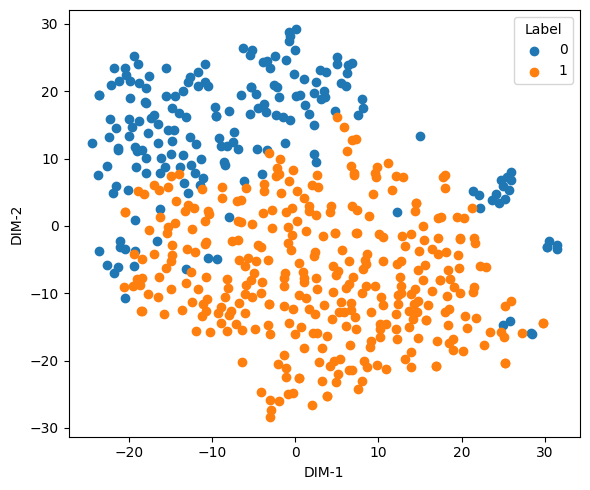

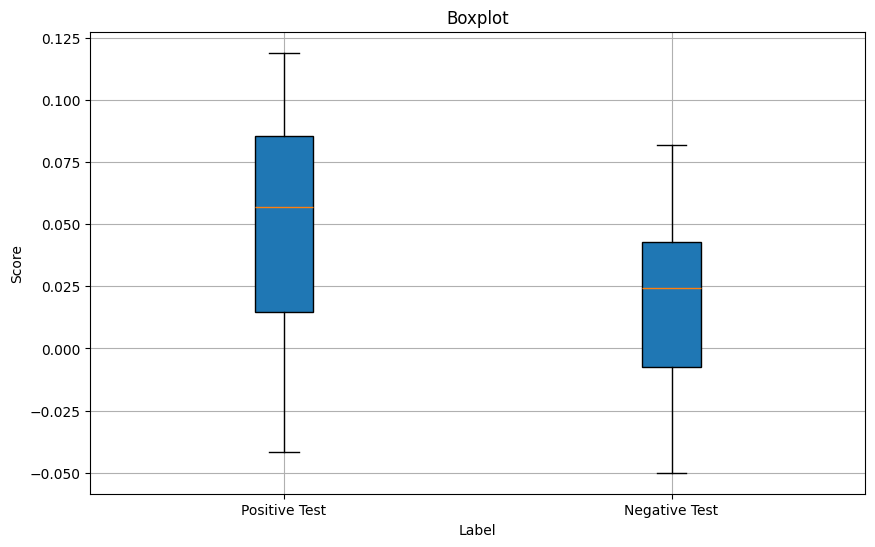

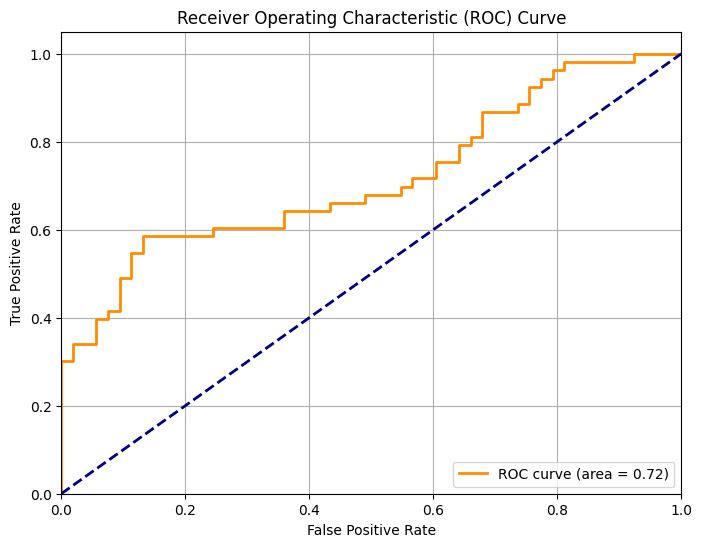

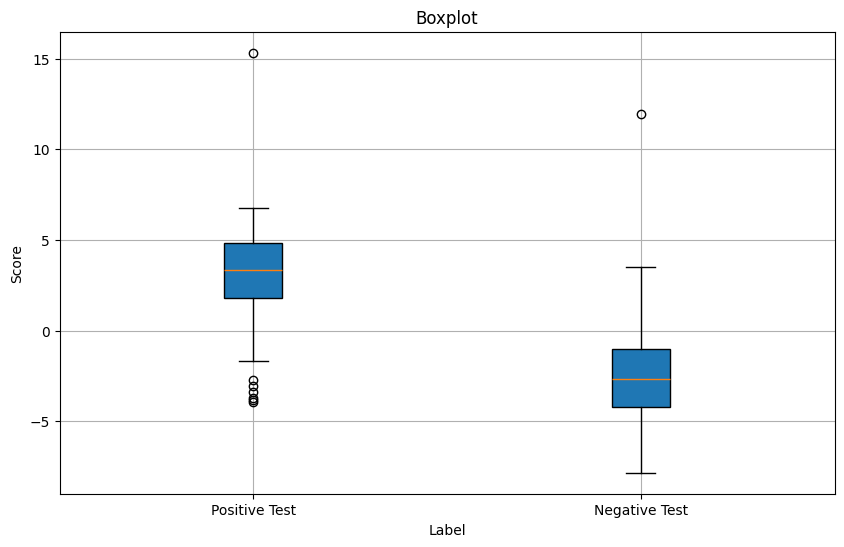

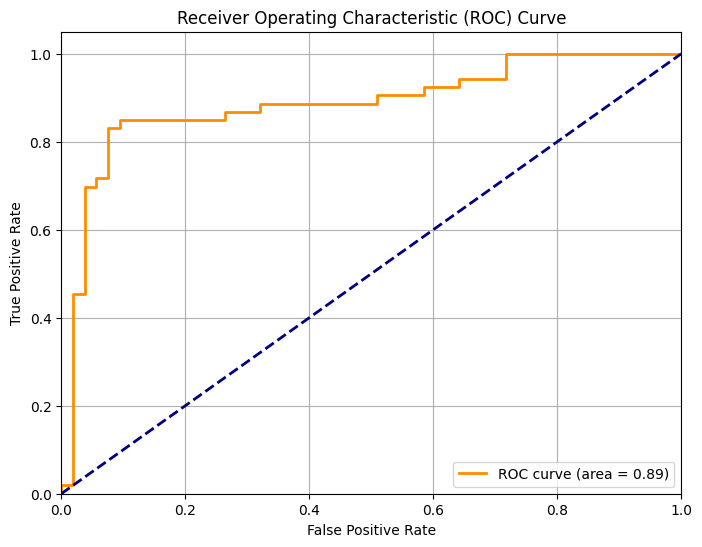

<Figure size 1000x1000 with 0 Axes>

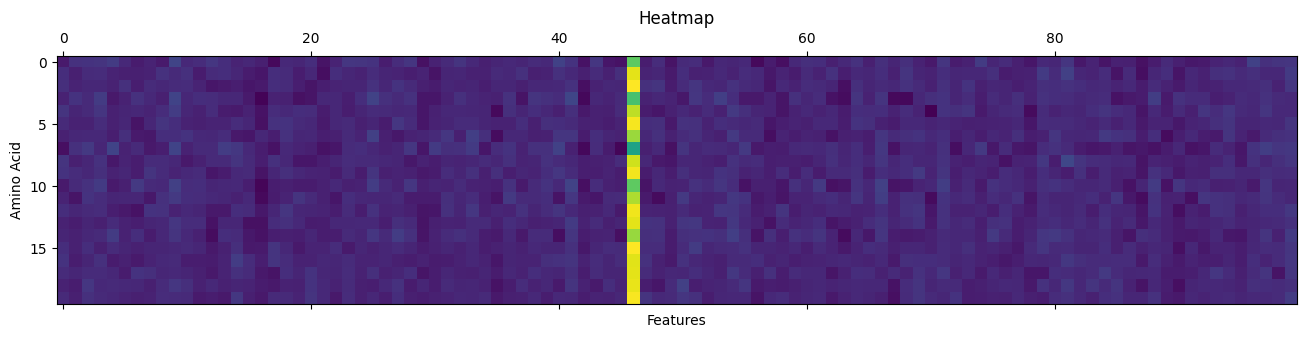

<Figure size 1000x1000 with 0 Axes>

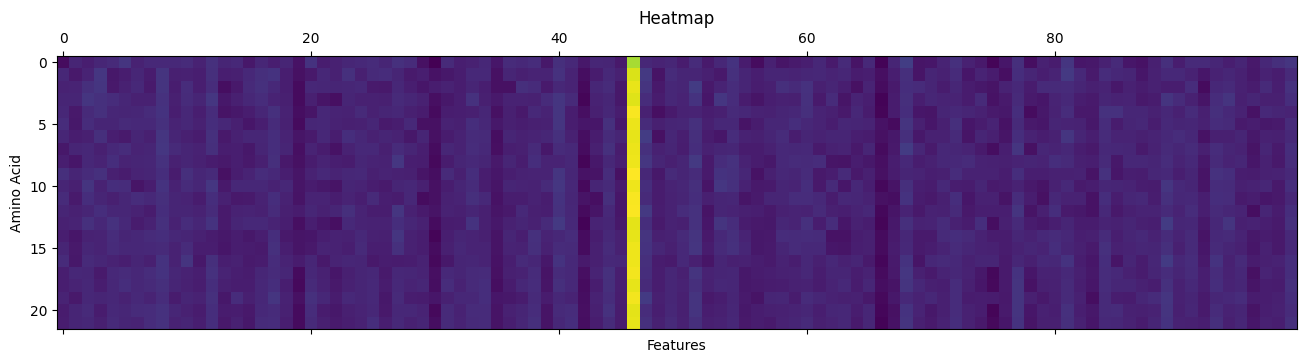

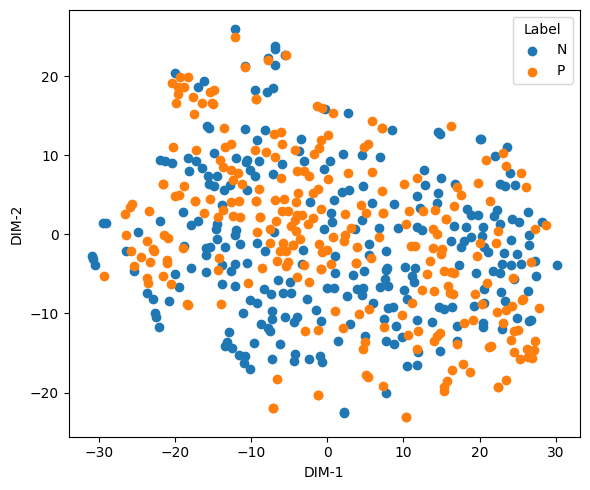

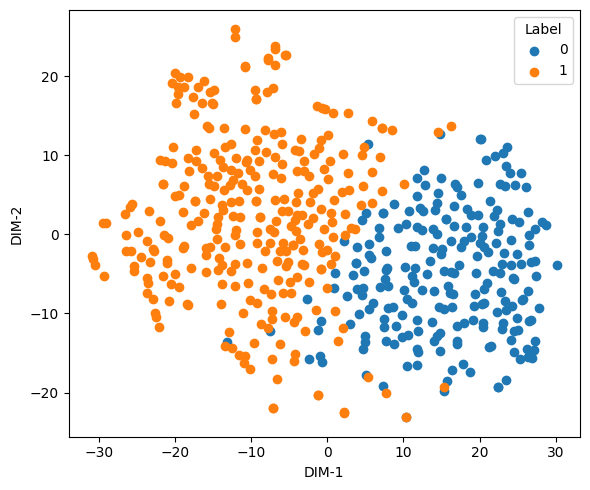

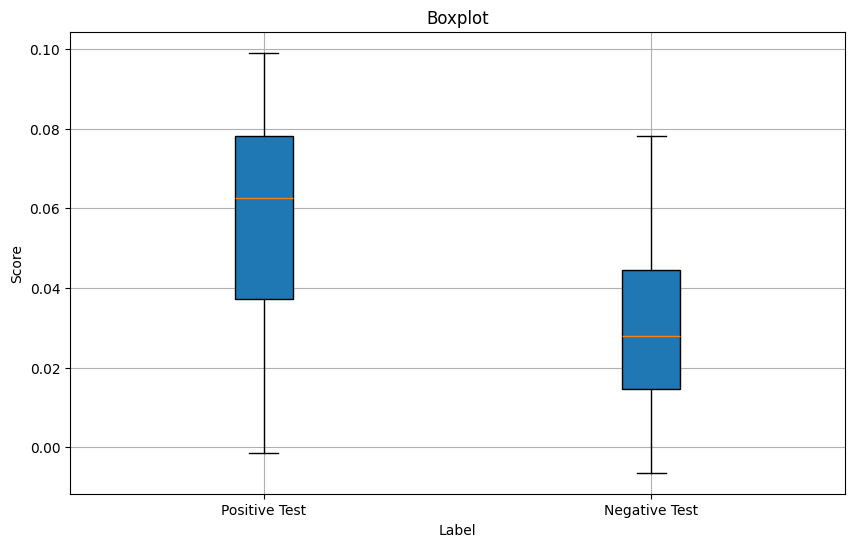

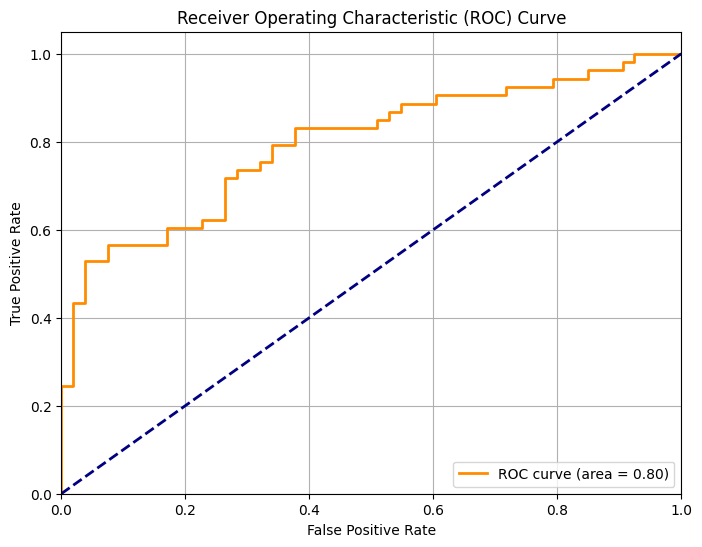

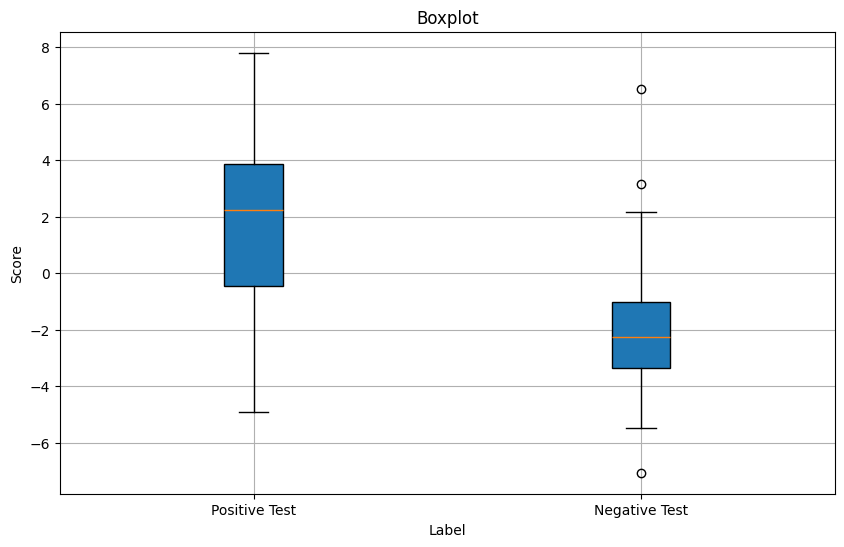

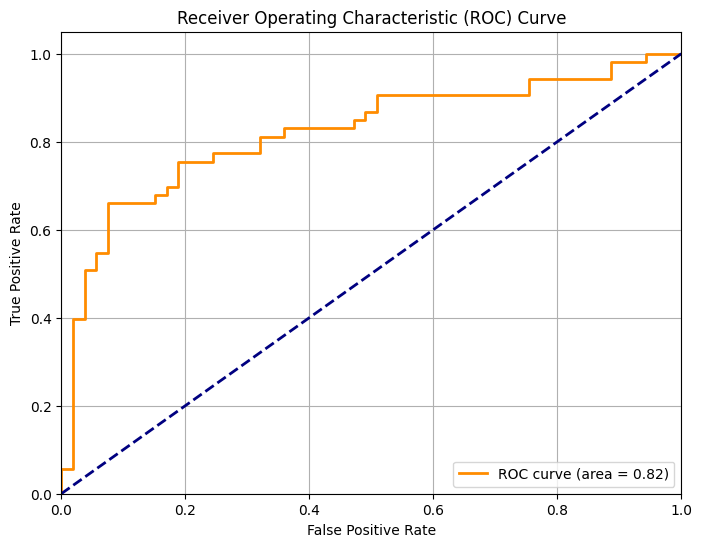

<Figure size 1000x1000 with 0 Axes>

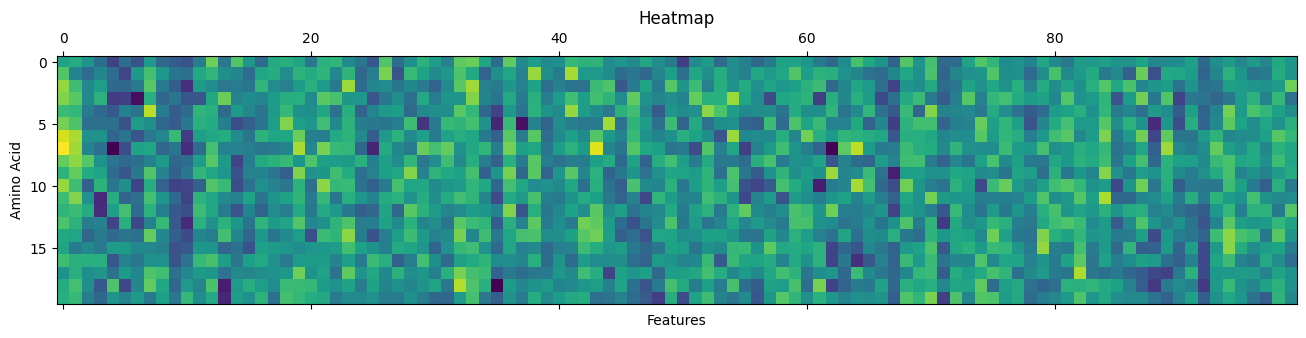

<Figure size 1000x1000 with 0 Axes>

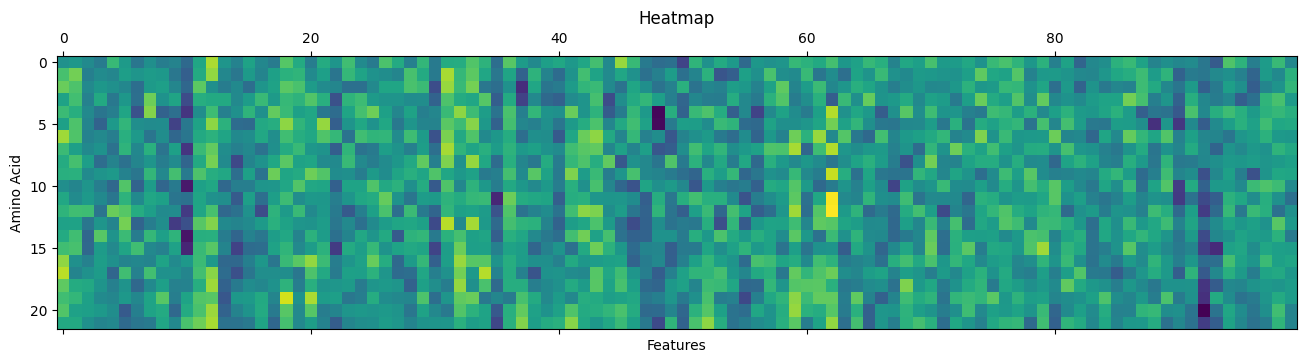

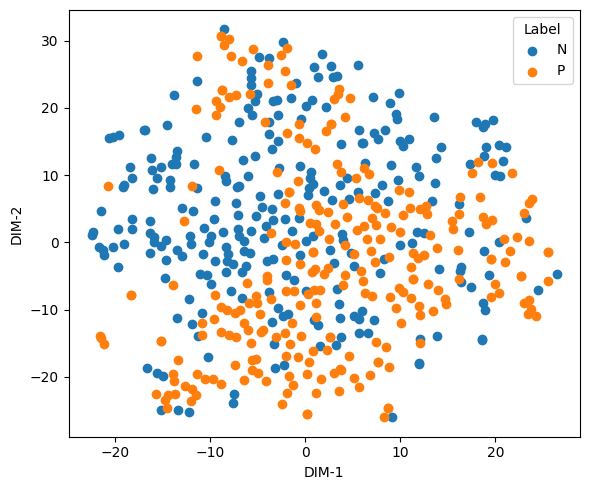

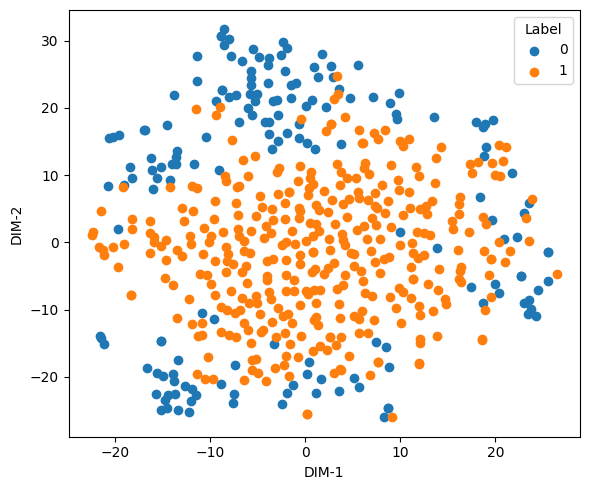

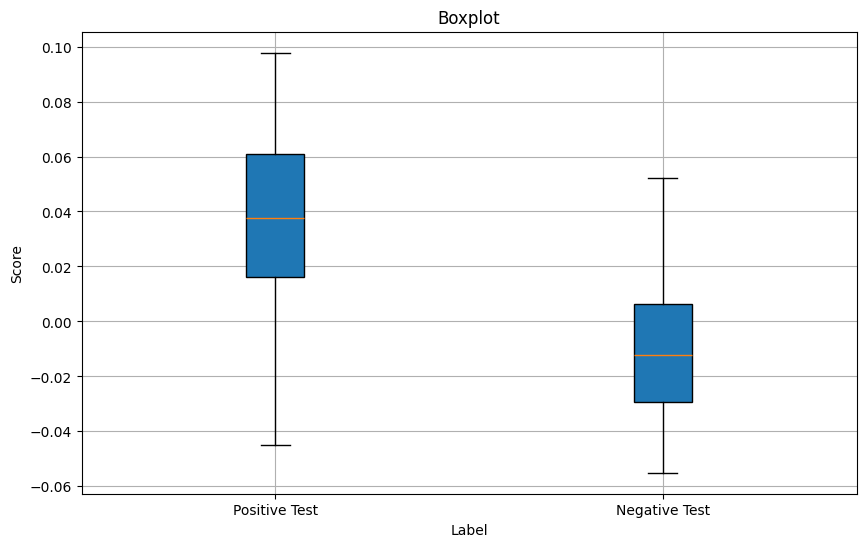

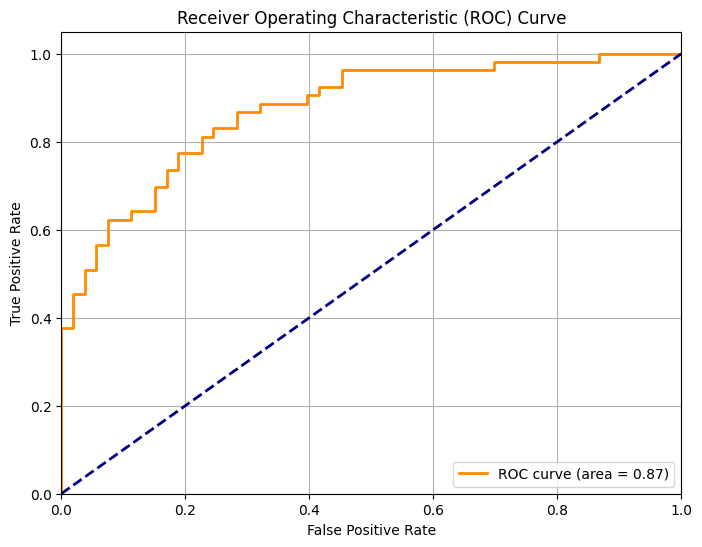

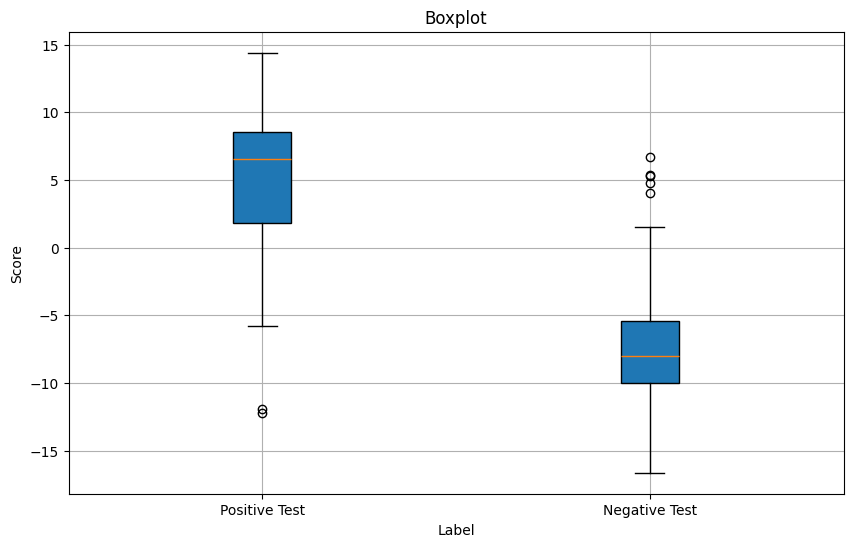

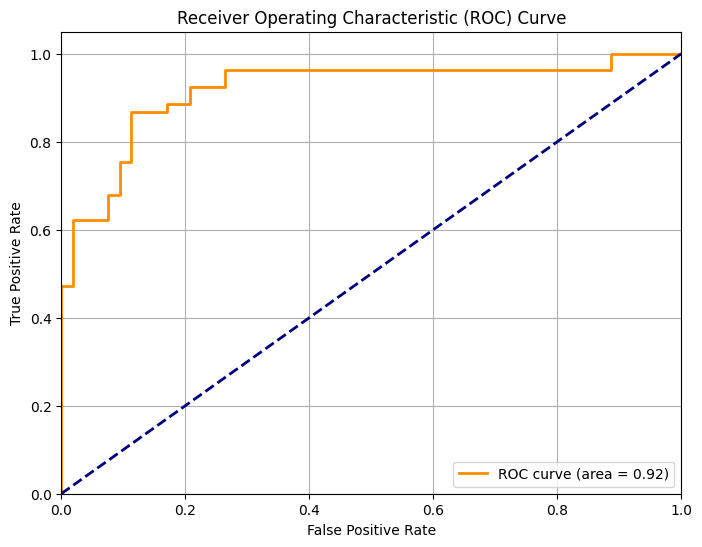

<Figure size 1000x1000 with 0 Axes>

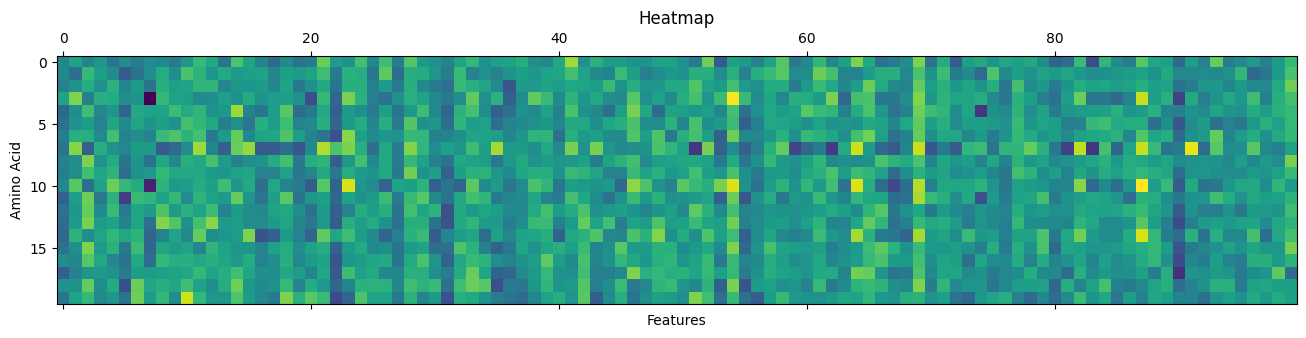

<Figure size 1000x1000 with 0 Axes>

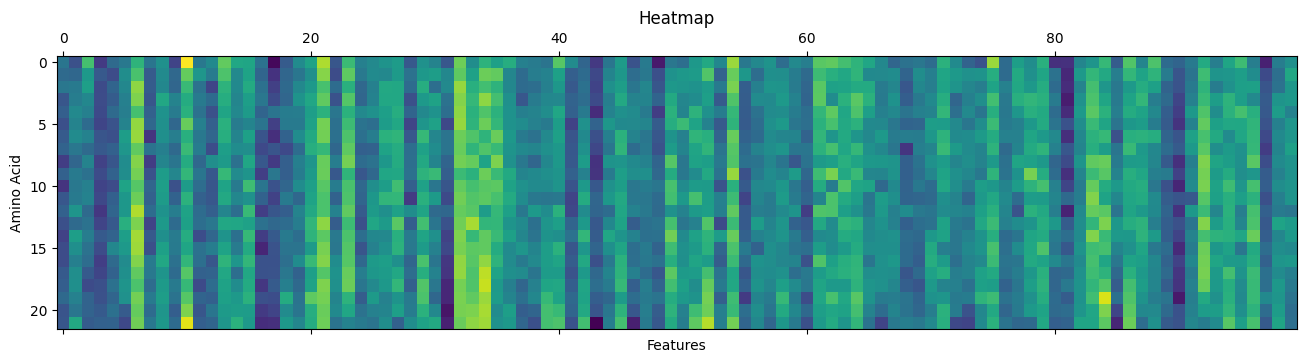

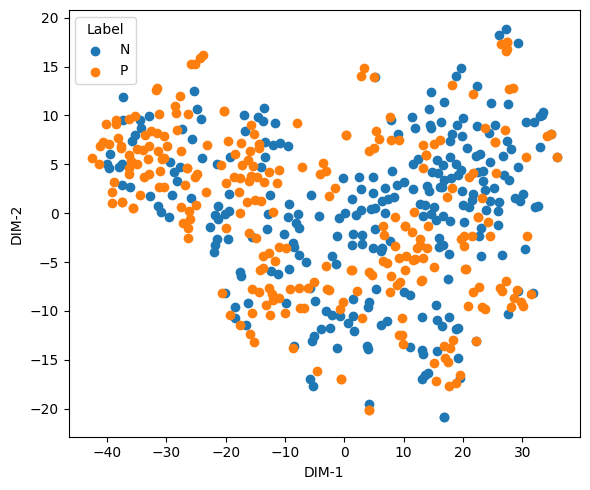

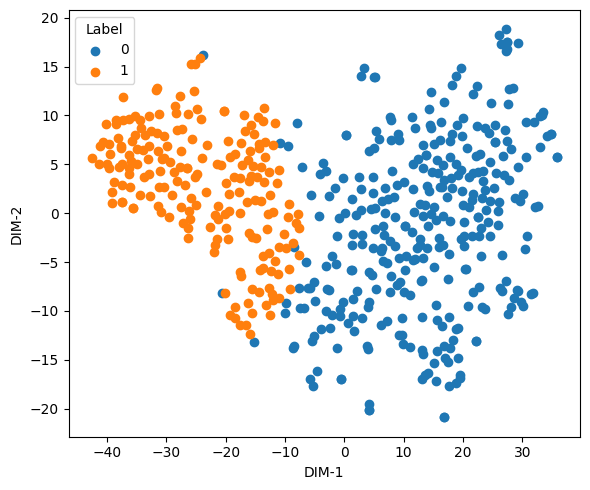

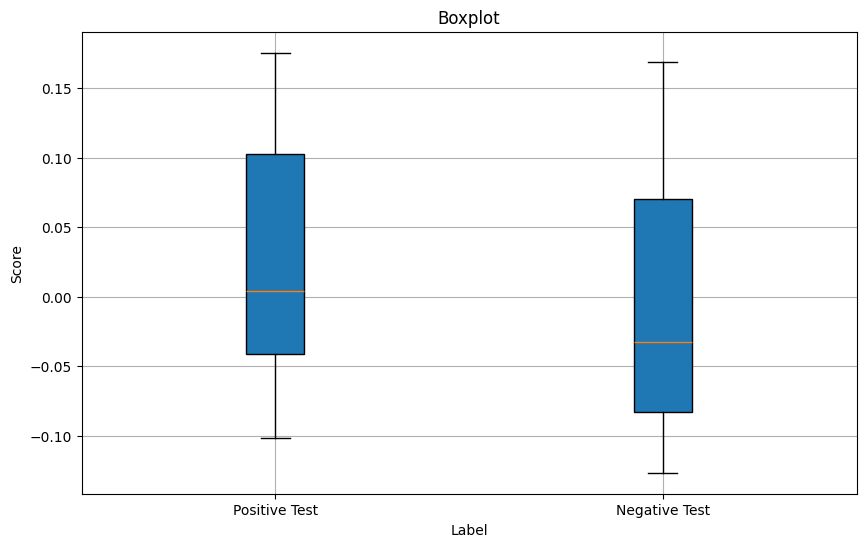

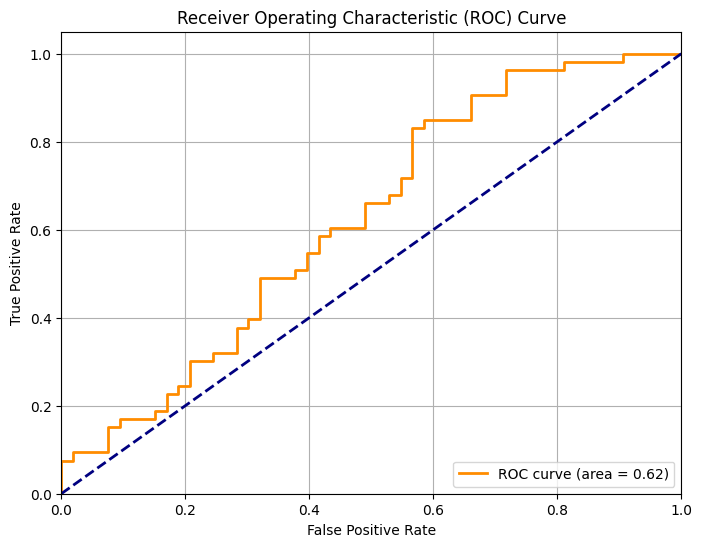

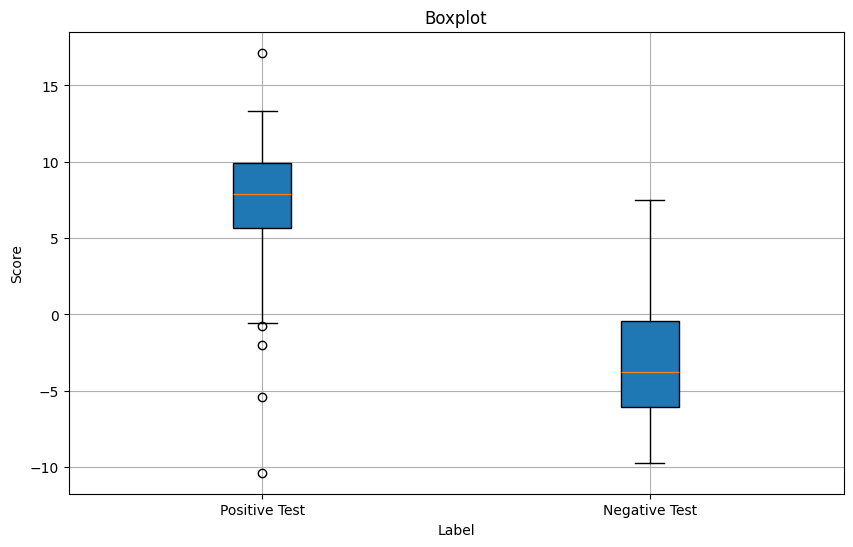

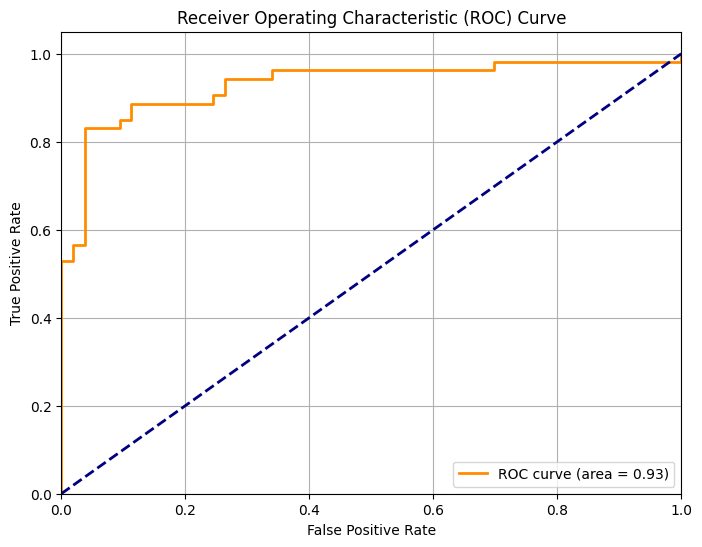

<Figure size 1000x1000 with 0 Axes>

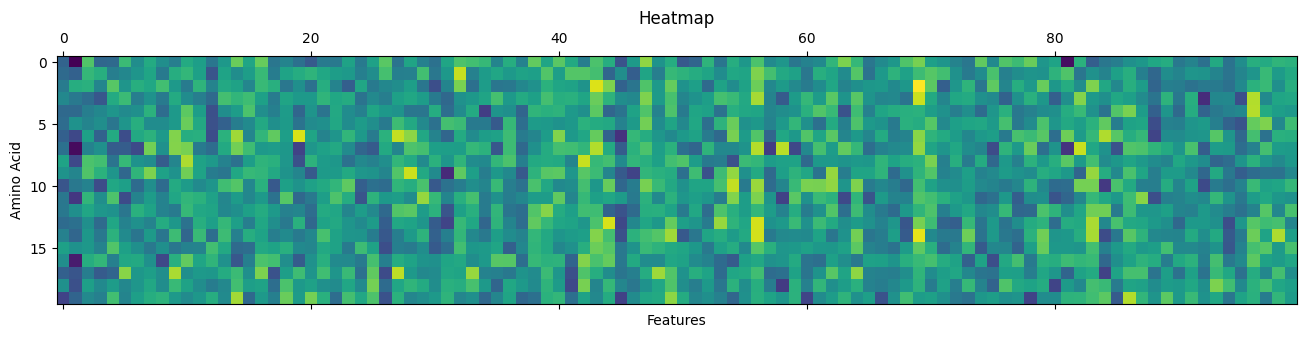

<Figure size 1000x1000 with 0 Axes>

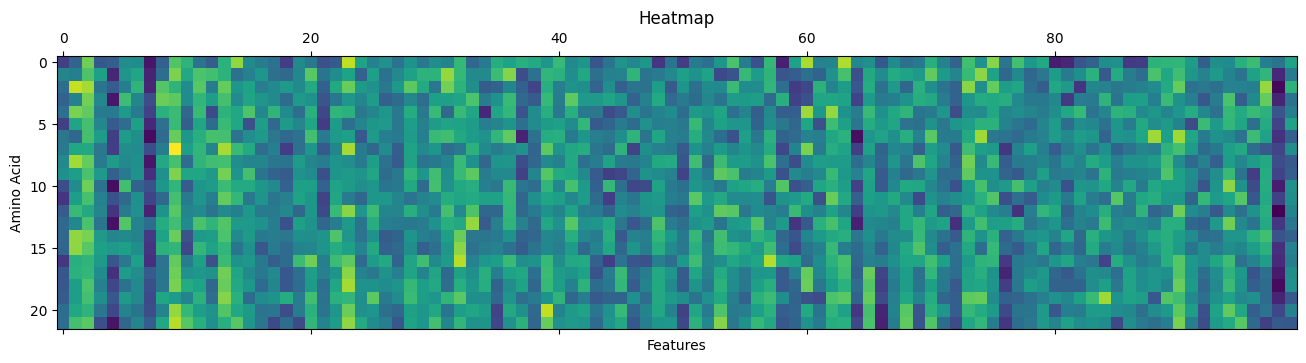

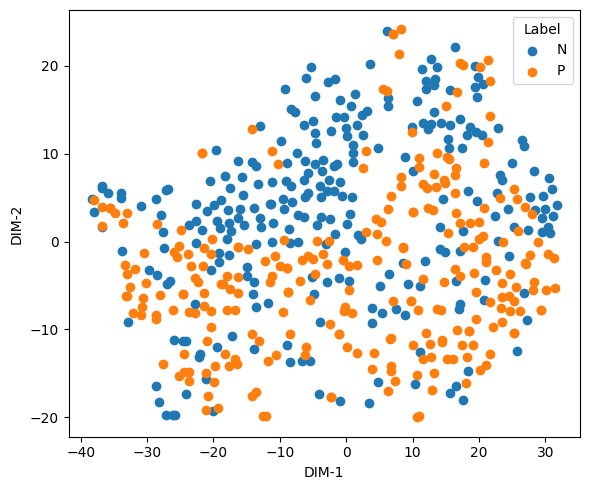

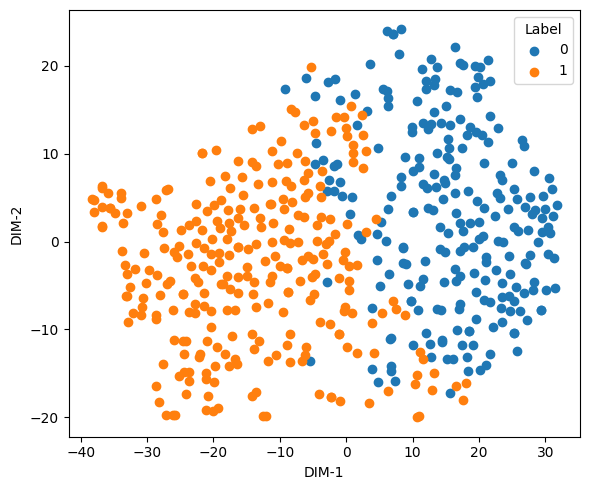

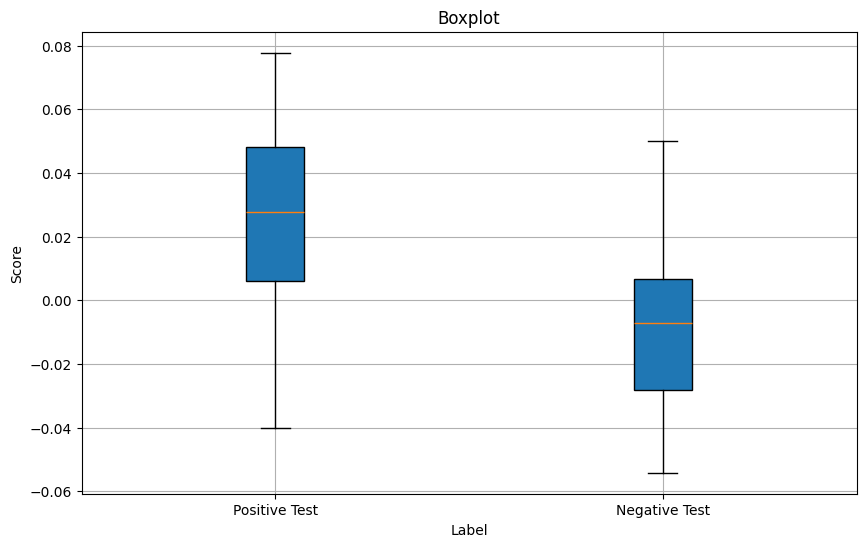

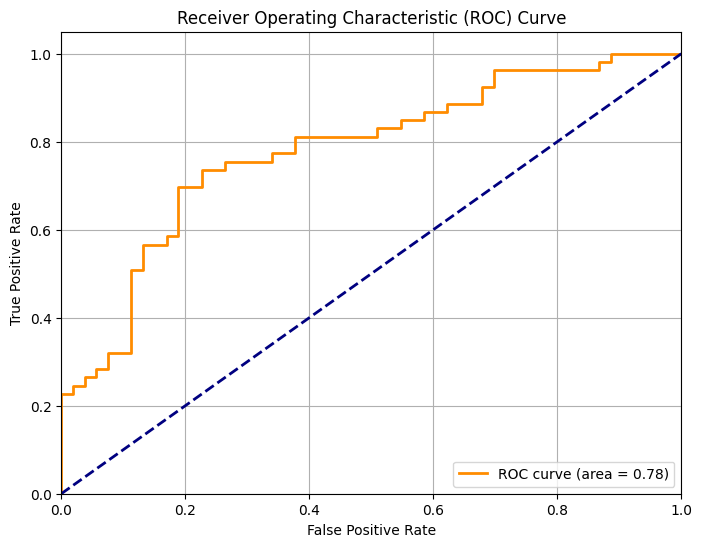

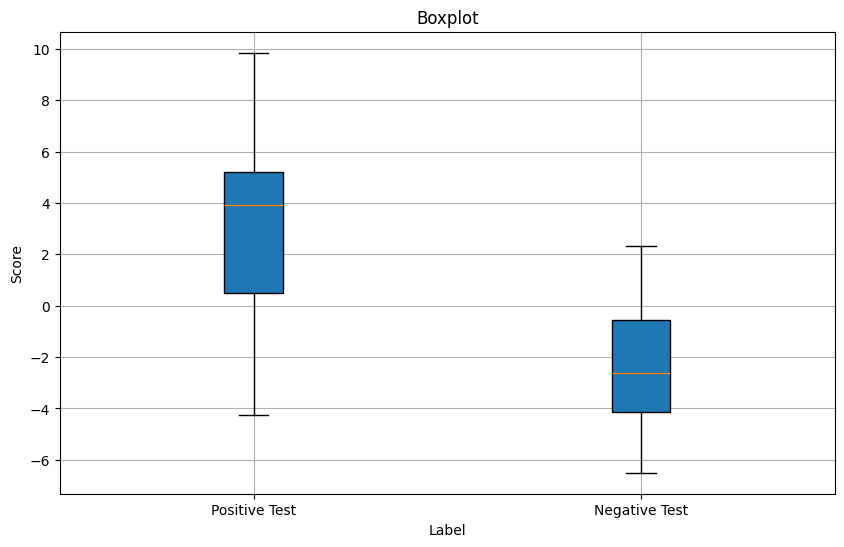

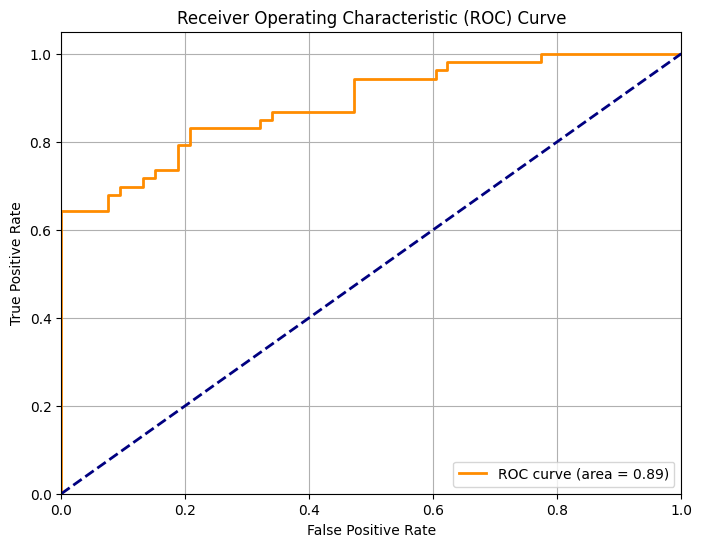

<Figure size 1000x1000 with 0 Axes>

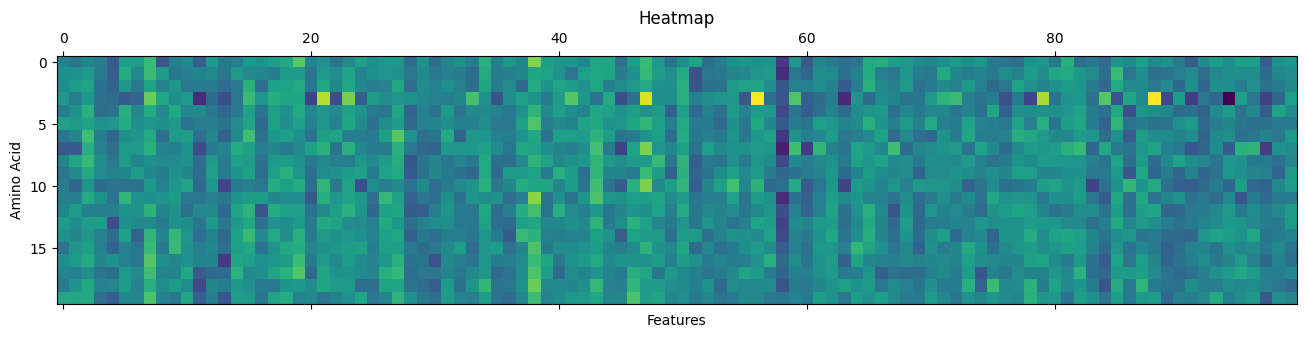

<Figure size 1000x1000 with 0 Axes>

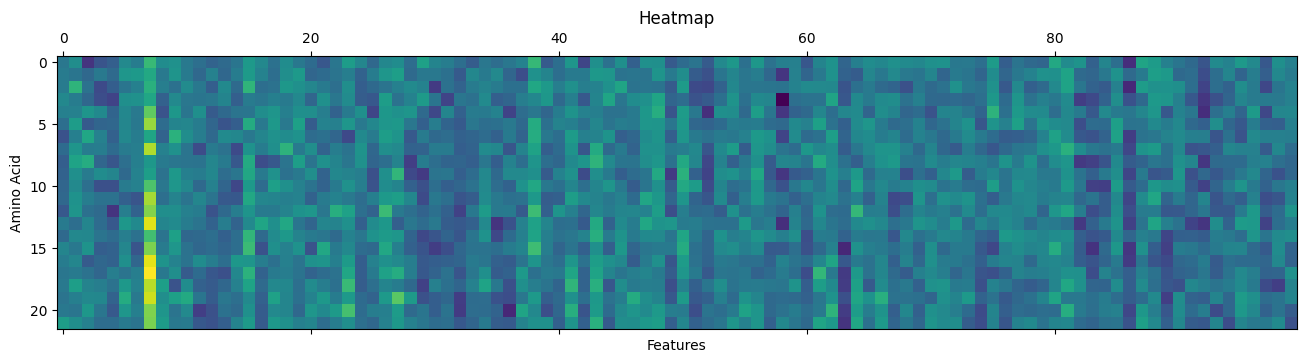

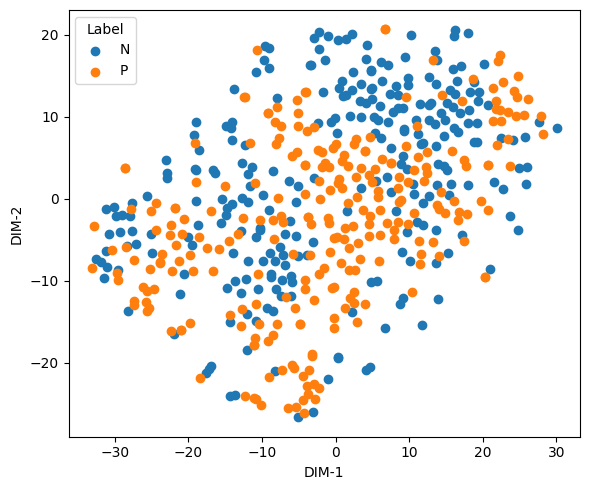

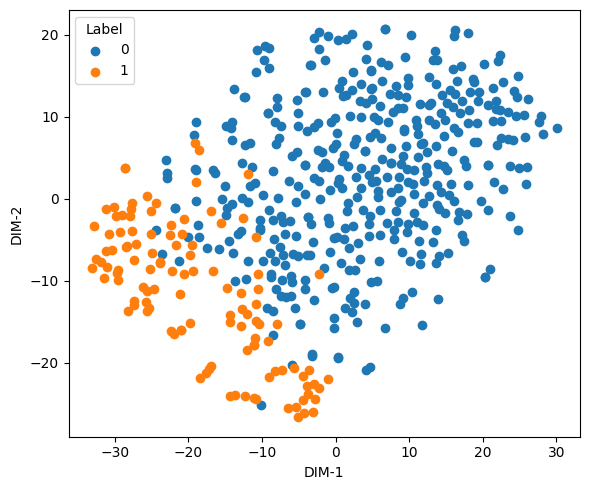

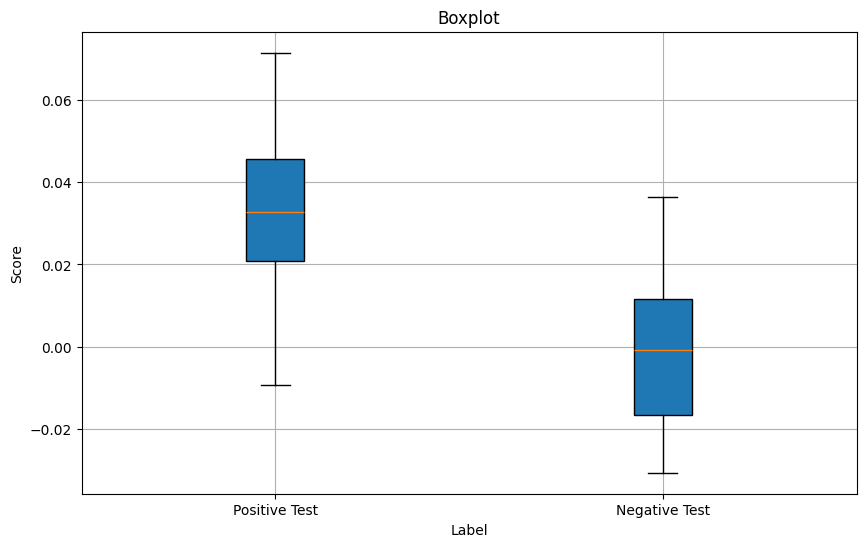

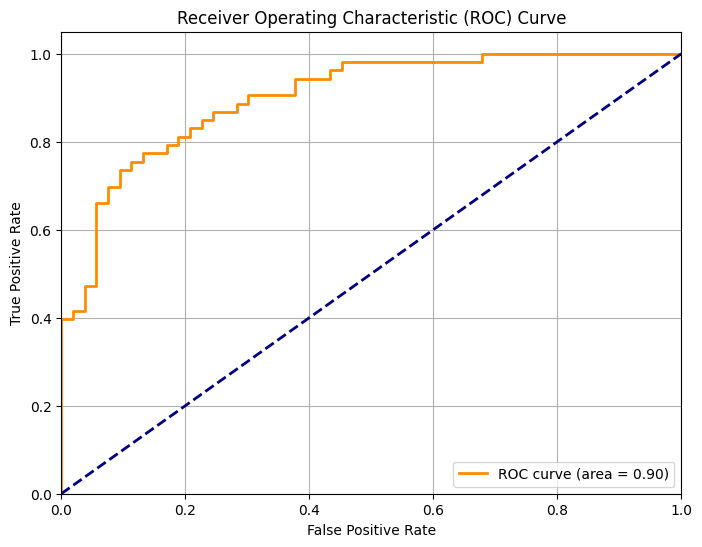

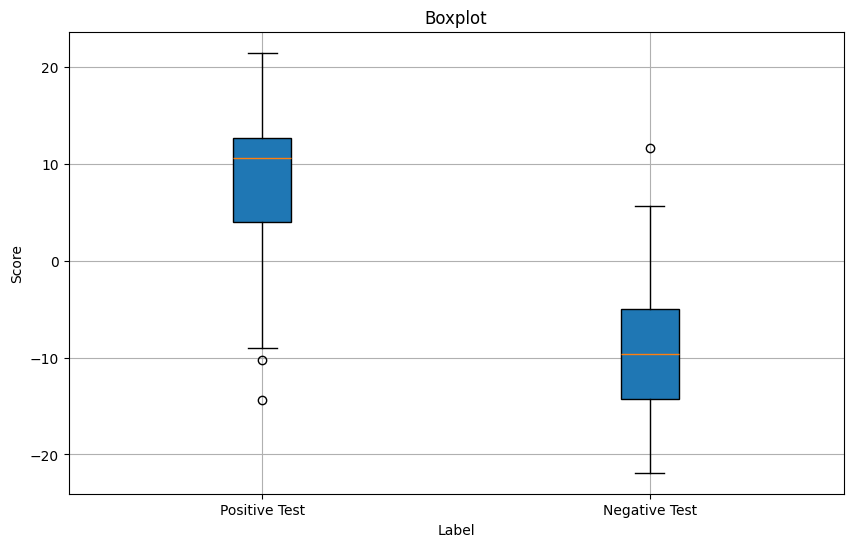

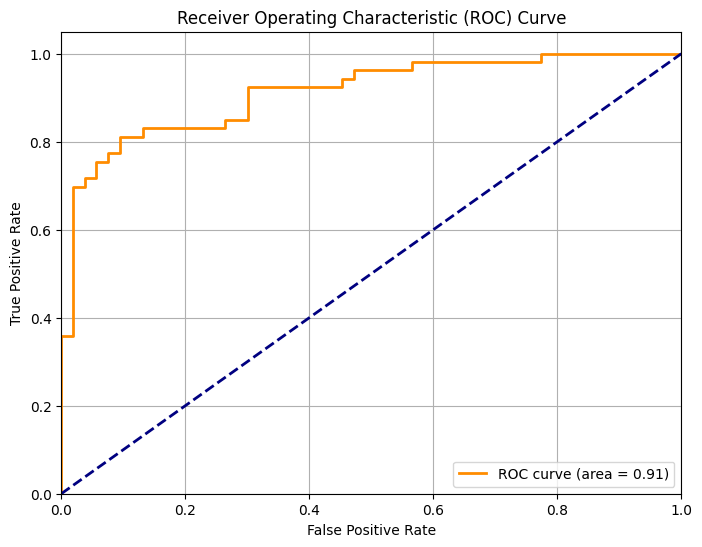

<Figure size 1000x1000 with 0 Axes>

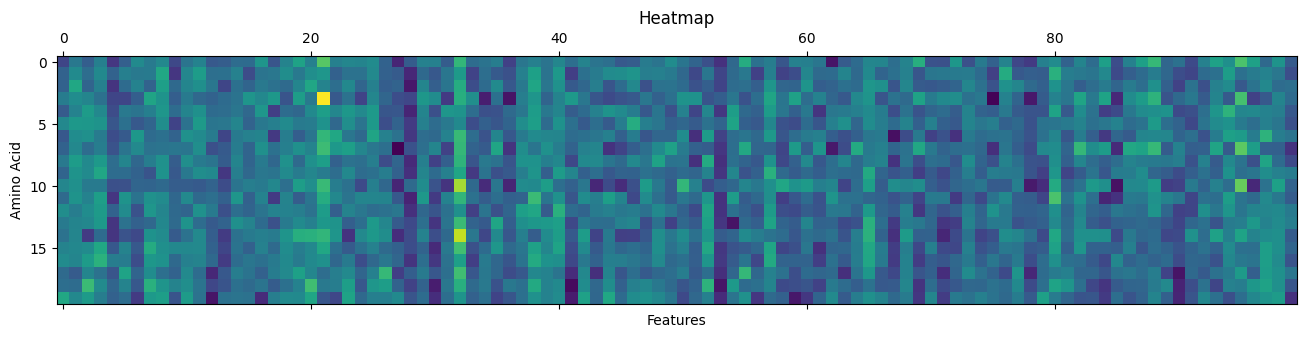

<Figure size 1000x1000 with 0 Axes>

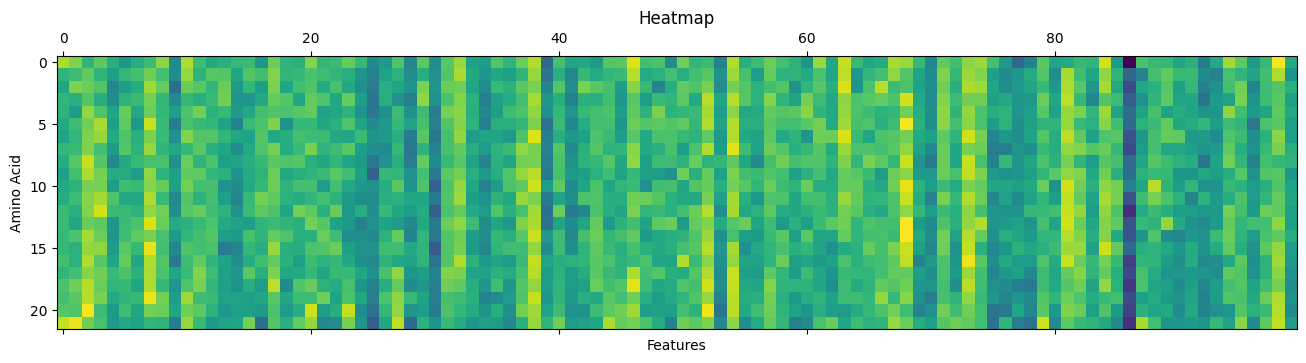

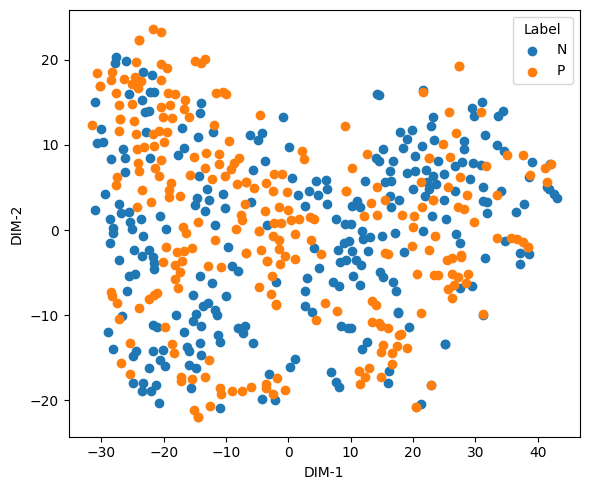

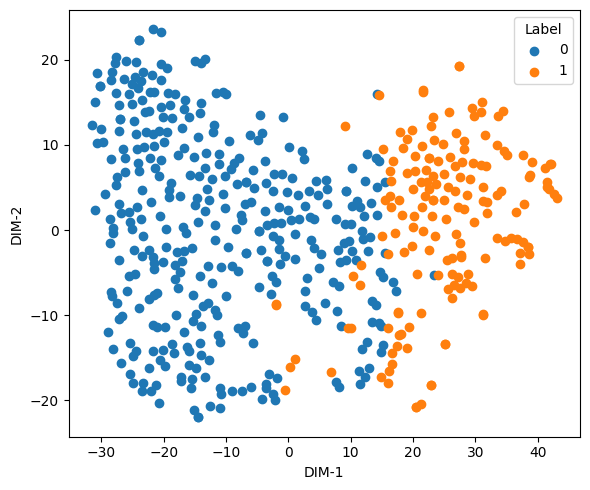

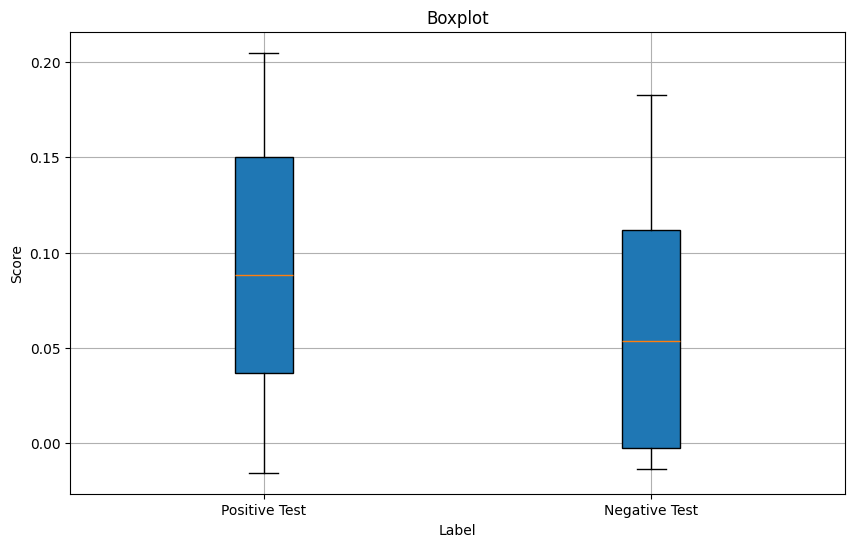

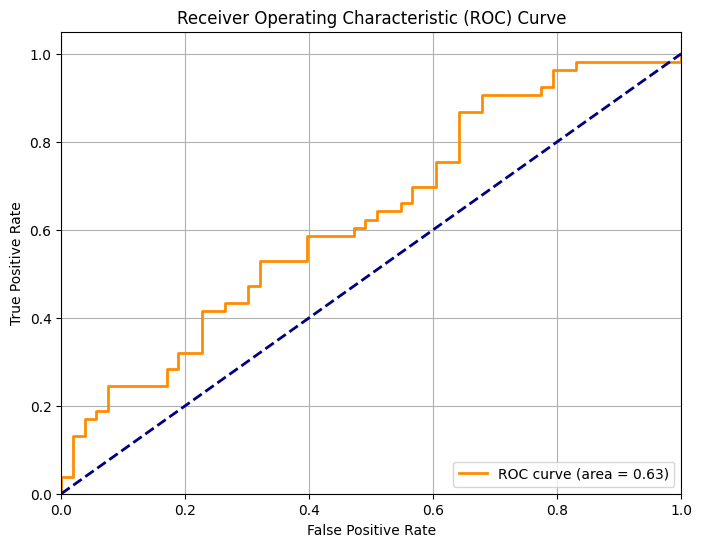

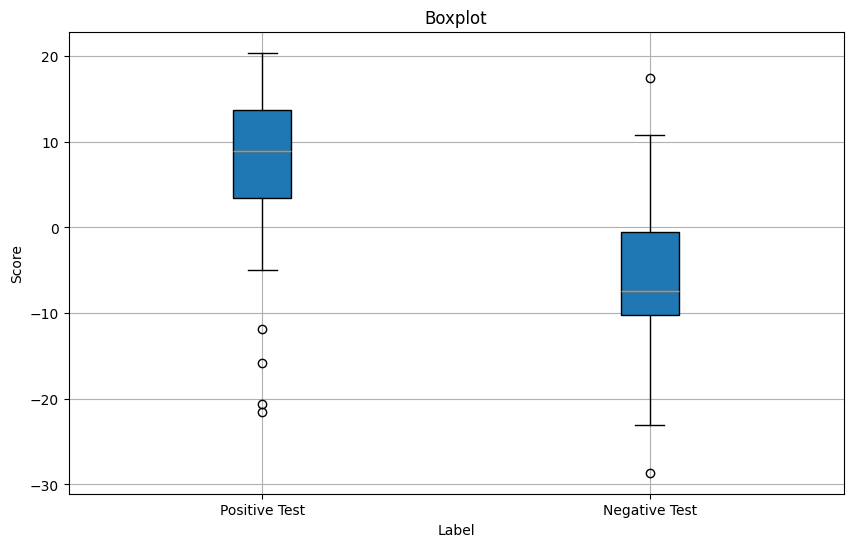

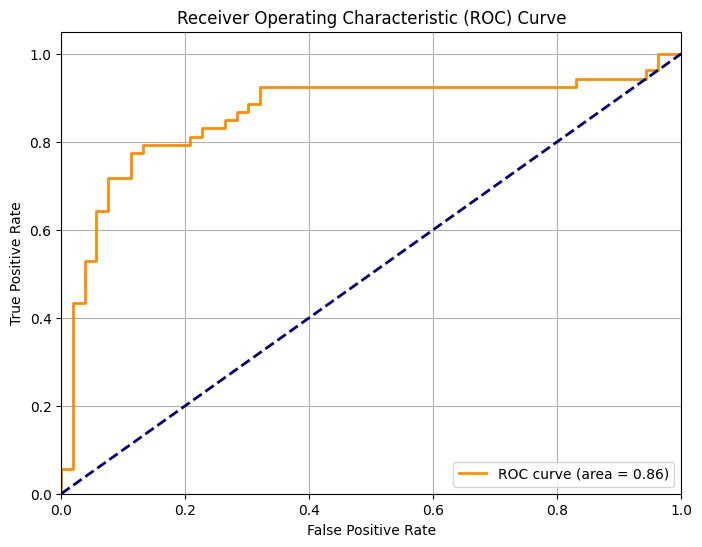

<Figure size 1000x1000 with 0 Axes>

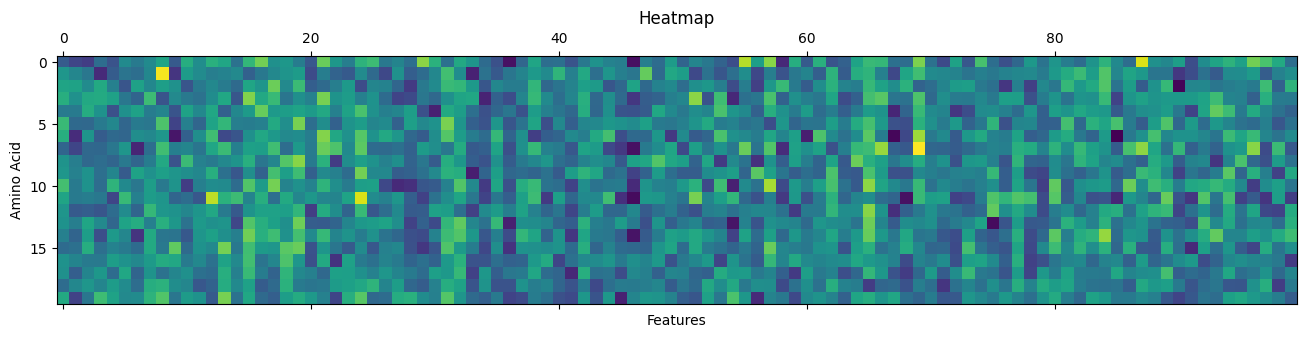

<Figure size 1000x1000 with 0 Axes>

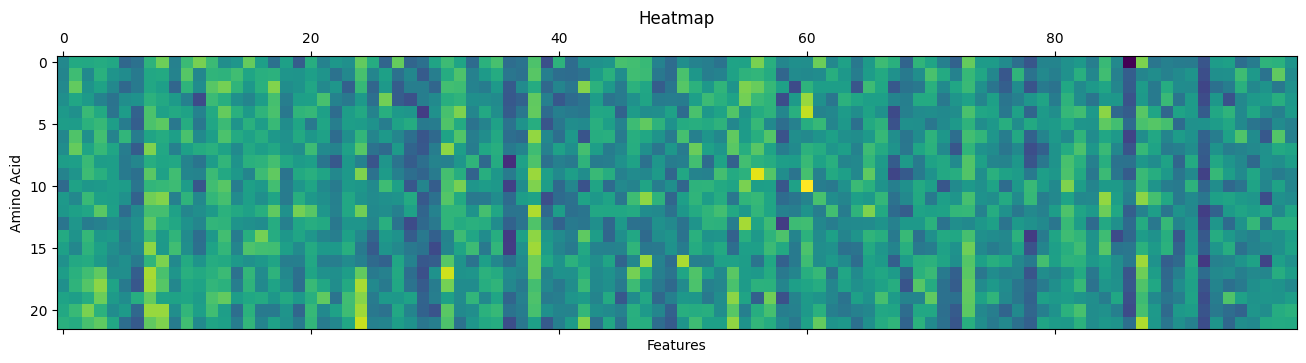

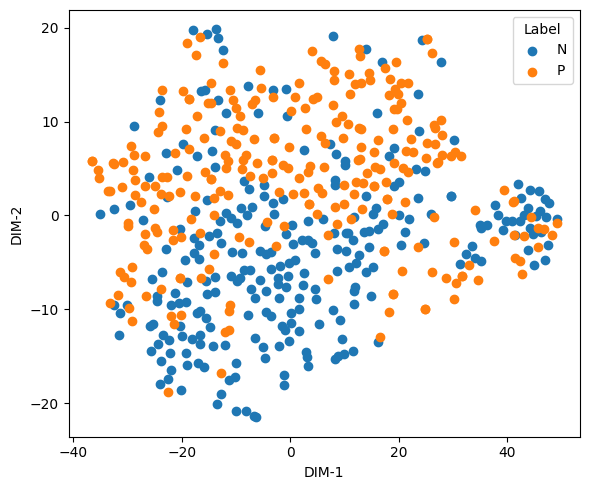

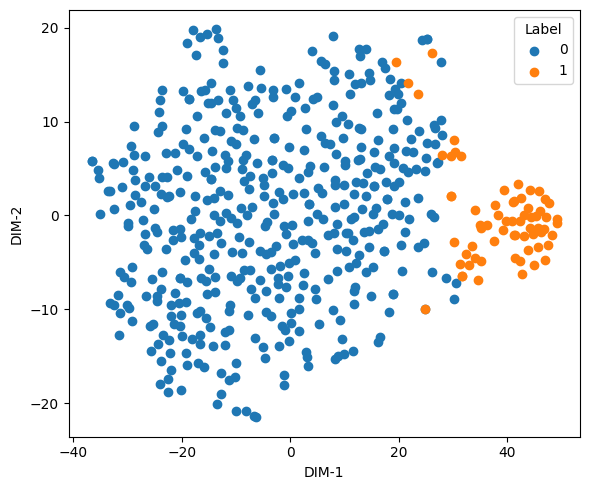

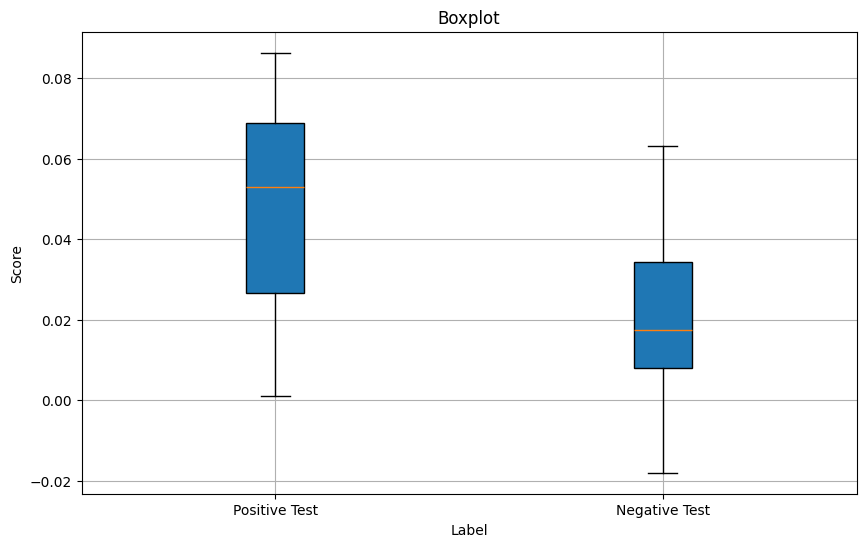

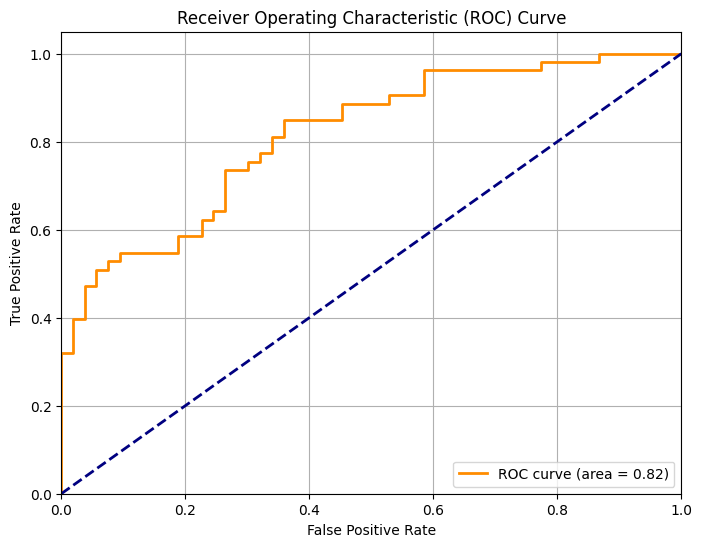

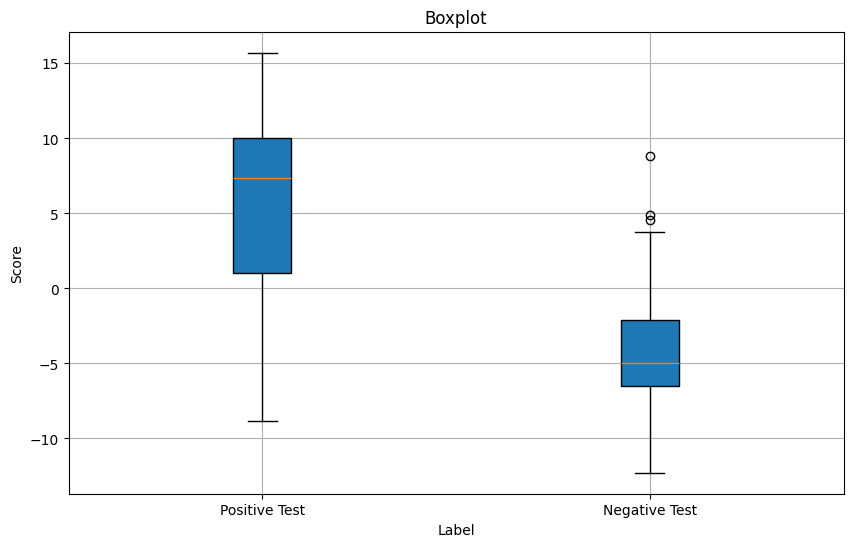

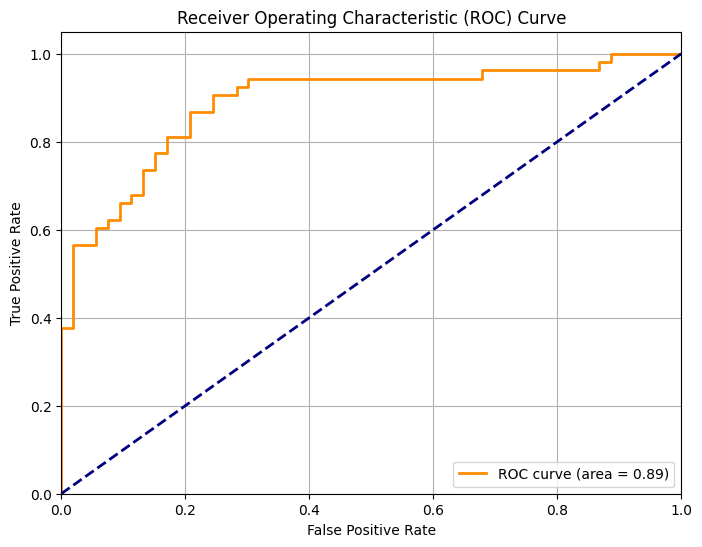

In [ ]:
configs = {320: [(2, 32, 30, 1e-3, 128, 0.4), (3, 32, 30, 1e-3, 128, 0.4), (6, 32, 30, 1e-3, 128, 0.4)],

           480: [(3, 32, 40, 1e-3, 128, 0.4), (6, 32, 40, 1e-3, 128, 0.4), (12, 32, 40, 1e-3, 128, 0.4)],

           640: [(5, 64, 50, 1e-3, 128, 0.4), (17, 64, 50, 1e-3, 128, 0.4), (30, 64, 50, 1e-3, 128, 0.4)],

           1280: [(9, 64, 60, 1e-3, 256, 0.4), (20, 64, 60, 1e-3, 256, 0.4), (33, 64, 60, 1e-3, 256, 0.4)]}

for config in configs:
    chosen_embedding_size = config
    for spec in configs[config]:
        chosen_embedding_layer, batch_size, epochs, lr, hidden_dim, dropout = spec
        name = f"/content/drive/MyDrive/Hackathon/results/{config}/{chosen_embedding_layer}_"

        print("Running network with the following configuration:")
        print(f"Embedding size: {chosen_embedding_size}")
        print(f"Embedding layer: {chosen_embedding_layer}")

        run_with_configuration(chosen_embedding_size=chosen_embedding_size, chosen_embedding_layer=chosen_embedding_layer, batch_size=batch_size, epochs=epochs, lr=lr, hidden_dim=hidden_dim, dropout=dropout, name=name)
        print("---------------------------------------------------------------")


Loading peptide data
Loading ESM-2 model


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t30_150M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t30_150M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D-contact-regression.pt


ESM model loaded to cuda
Getting ESM-2 amino acid embeddings for the first negative and positive peptides
Plotting heatmaps of the amino acid embedding
Getting the ESM-2 embeddings for all the peptide data
Clustering using K-means clustering and reduce to dim=2 using TSNE
Plotting 2D dimensionality reduction by true labels and by K-means clustering
Splitting to train and test sets
Calculating euclidean distances of ESM-2 embeddings
Plotting Baseline results
AUC: 0.6226415094339622
Training a neural network on the training set
Epoch 01/50 – loss: 0.7058
Epoch 02/50 – loss: 0.6497
Epoch 03/50 – loss: 0.6169
Epoch 04/50 – loss: 0.5852
Epoch 05/50 – loss: 0.5172
Epoch 06/50 – loss: 0.4751
Epoch 07/50 – loss: 0.4318
Epoch 08/50 – loss: 0.3964
Epoch 09/50 – loss: 0.3798
Epoch 10/50 – loss: 0.3549
Epoch 11/50 – loss: 0.3185
Epoch 12/50 – loss: 0.2942
Epoch 13/50 – loss: 0.2710
Epoch 14/50 – loss: 0.2469
Epoch 15/50 – loss: 0.2543
Epoch 16/50 – loss: 0.2667
Epoch 17/50 – loss: 0.2775
Epoch 18/

<Figure size 1000x1000 with 0 Axes>

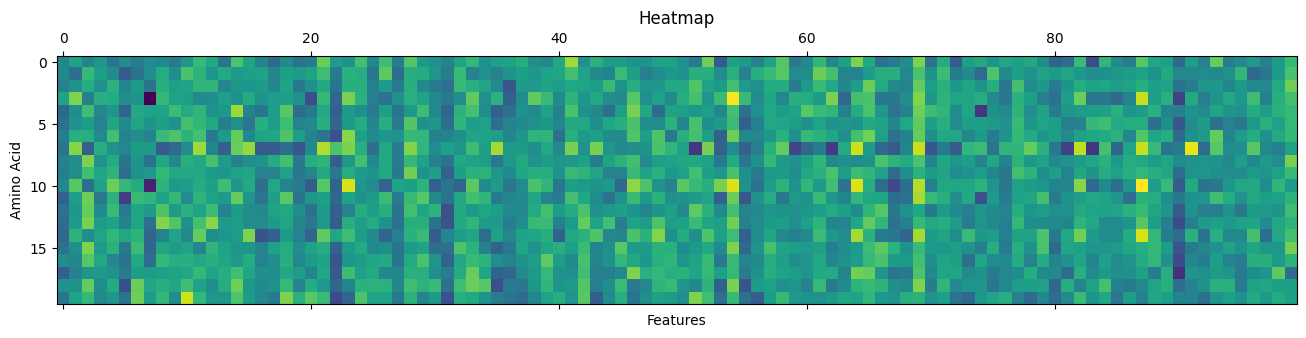

<Figure size 1000x1000 with 0 Axes>

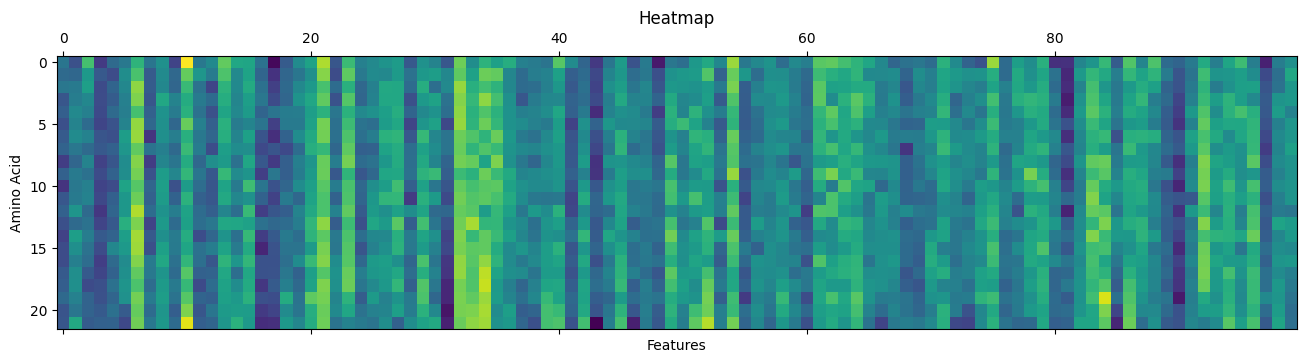

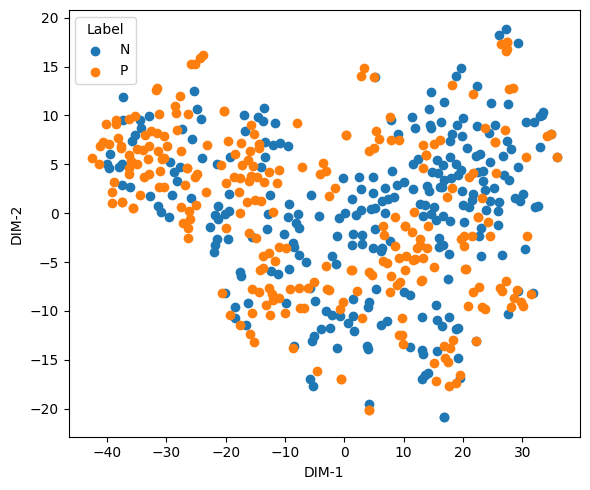

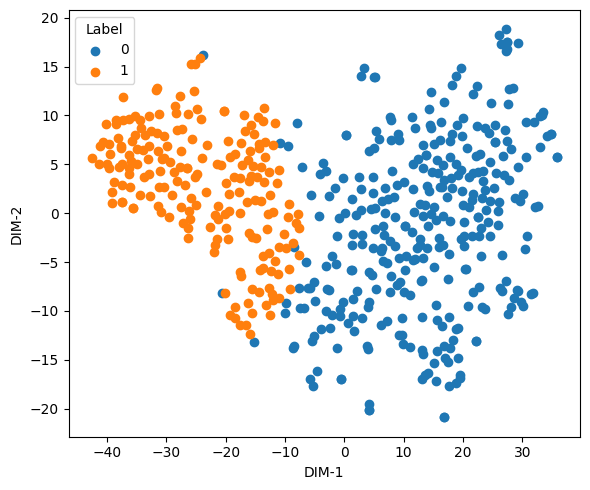

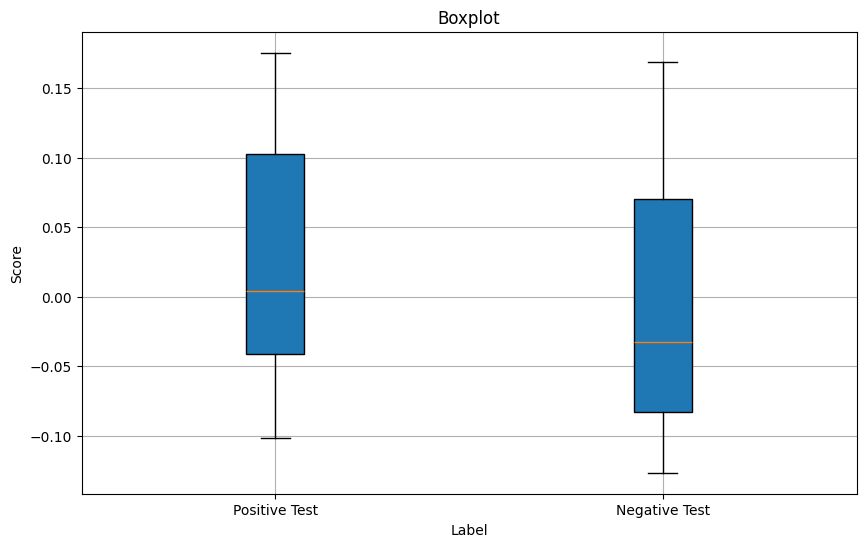

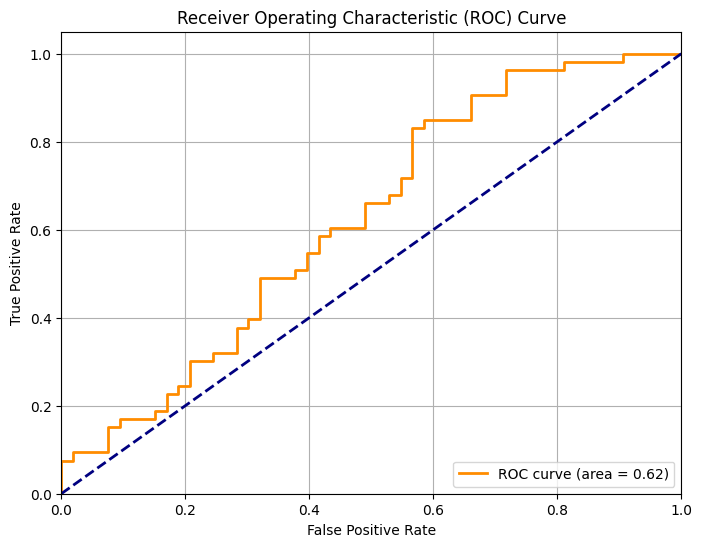

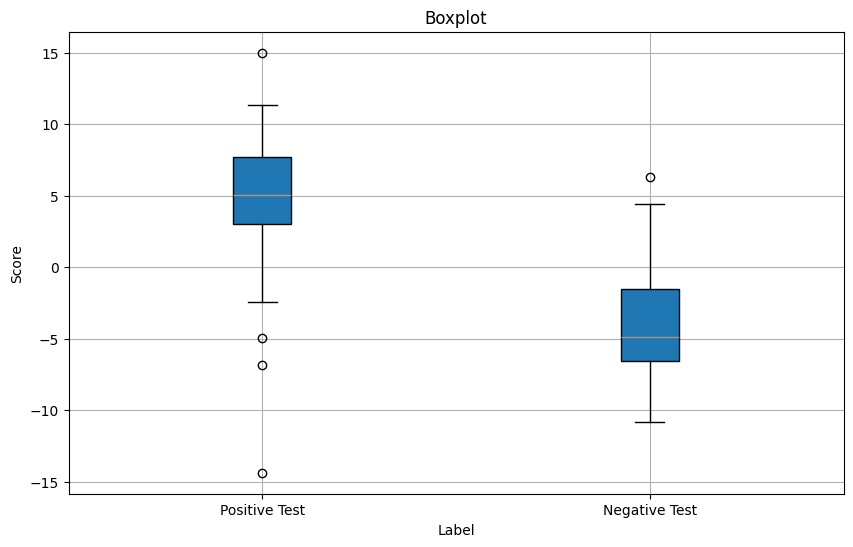

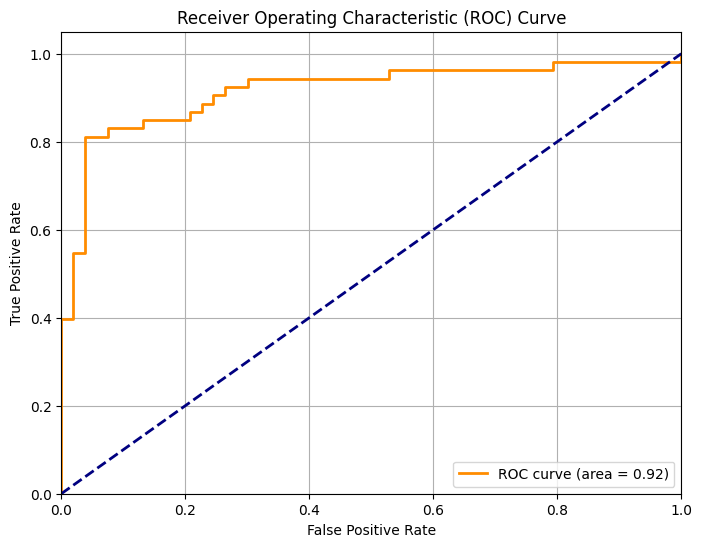

In [ ]:
best_config = (17, 64, 50, 1e-3, 128, 0.4)
best_embedding_size = 640

chosen_embedding_layer, batch_size, epochs, lr, hidden_dim, dropout = best_config
name = f"/content/drive/MyDrive/Hackathon/results/best/"
run_with_configuration(chosen_embedding_size=best_embedding_size, chosen_embedding_layer=chosen_embedding_layer, batch_size=batch_size, epochs=epochs, lr=lr, hidden_dim=hidden_dim, dropout=dropout, name=name)